In [1]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import numpy as np
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import pickle


from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import plotly.graph_objects as go

from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy


In [3]:
chunksize = 10 ** 5
train_df = pd.DataFrame()
for chunk in pd.read_csv("C:/Users/sachi/Downloads/amex-default-prediction/train_data.csv", chunksize=chunksize):
    train_df = pd.concat([train_df, chunk])

In [4]:
train_df.shape

(5531451, 190)

In [5]:
train_df.isna().sum()*100/len(train_df)

customer_ID     0.000000
S_2             0.000000
P_2             0.831337
D_39            0.000000
B_1             0.000000
B_2             0.036446
R_1             0.000000
S_3            18.449843
D_41            0.036446
B_3             0.036446
D_42           85.694278
D_43           29.981211
D_44            4.959259
B_4             0.000000
D_45            0.036464
B_5             0.000000
R_2             0.000000
D_46           21.905627
D_47            0.000000
D_48           12.993426
D_49           90.137597
B_6             0.004212
B_7             0.000000
B_8             0.402571
D_50           56.809723
D_51            0.000000
B_9             0.000000
R_3             0.000000
D_52            0.534453
P_3             5.450505
B_10            0.000000
D_53           73.842921
S_5             0.000000
B_11            0.000000
S_6             0.000000
D_54            0.036446
R_4             0.000000
S_7            18.449843
B_12            0.000000
S_8             0.000000


In [6]:
train_df.head(10)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,NaN,NaN,0.000630,0.080986,0.708906,0.170600,0.006204,0.358587,0.525351,0.255736,NaN,0.063902,0.059416,0.006466,0.148698,1.335856,0.008207,0.001423,0.207334,0.736463,0.096219,NaN,0.023381,0.002768,0.008322,1.001519,0.008298,0.161345,0.148266,0.922998,0.354596,0.152025,0.118075,0.001882,0.158612,0.065728,0.018385,0.063646,0.199617,0.308233,0.016361,0.401619,0.091071,CR,O,0.007126,0.007665,NaN,0.652984,0.008520,NaN,0.004730,6.0,0.272008,0.008363,0.515222,0.002644,0.009013,0.004808,0.008342,0.119403,0.004802,0.108271,0.050882,NaN,0.007554,0.080422,0.069067,NaN,0.004327,0.007562,NaN,0.007729,0.000272,0.001576,0.004239,0.001434,NaN,0.002271,0.004061,0.007121,0.002456,0.002310,0.003532,0.506612,0.008033,1.009825,0.084683,0.003820,0.007043,0.000438,0.006452,0.000830,0.005055,NaN,0.0,0.005720,0.007084,NaN,0.000198,0.008907,NaN,1,0.002537,0.005177,0.006626,0.009705,0.007782,0.002450,1.001101,0.002665,0.007479,0.006893,1.503673,1.006133,0.003569,0.008871,0.003950,0.003647,0.004950,0.894090,0.135561,0.911191,0.974539,0.001243,0.766688,1.008691,1.004587,0.893734,NaN,0.670041,0.009968,0.004572,NaN,1.008949,2.0,NaN,0.004326,NaN,NaN,NaN,1.007336,0.210060,0.676922,0.007871,1.0,0.238250,0.0,4.0,0.232120,0.236266,0.0,0.702280,0.434345,0.003057,0.686516,0.008740,1.0,1.003319,1.007819,1.000080,0.006805,NaN,0.002052,0.005972,NaN,0.004345,0.001535,NaN,NaN,NaN,NaN,NaN,0.002427,0.003706,0.003818,NaN,0.000569,0.000610,0.002674
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,NaN,NaN,0.002526,0.069419,0.712795,0.113239,0.006206,0.353630,0.521311,0.223329,NaN,0.065261,0.057744,0.001614,0.149723,1.339794,0.008373,0.001984,0.202778,0.720886,0.099804,NaN,0.030599,0.002749,0.002482,1.009033,0.005136,0.140951,0.143530,0.919414,0.326757,0.156201,0.118737,0.001610,0.148459,0.093935,0.013035,0.065501,0.151387,0.265026,0.017688,0.406326,0.086805,CR,O,0.002413,0.007148,NaN,0.647093,0.002238,NaN,0.003879,6.0,0.188970,0.004030,0.509048,0.004193,0.007842,0.001283,0.006524,0.140611,0.000094,0.101018,0.040469,NaN,0.004832,0.081413,0.074166,NaN,0.004203,0.005304,NaN,0.001864,0.000979,0.009896,0.007597,0.000509,NaN,0.009810,0.000127,0.005966,0.000395,0.001327,0.007773,0.500855,0.000760,1.009461,0.081843,0.000347,0.007789,0.004311,0.002332,0.009469,0.003753,NaN,0.0,0.007584,0.006677,NaN,0.001142,0.005907,NaN,1,0.008427,0.008979,0.001854,0.009924,0.005987,0.002247,1.006779,0.002508,0.006827,0.002837,1.503577,1.005791,0.000571,0.000391,0.008351,0.008850,0.003180,0.902135,0.136333,0.919876,0.975624,0.004561,0.786007,1.000084,1.004118,0.906841,NaN,0.668647,0.003921,0.004654,NaN,1.003205,2.0,NaN,0.008707,NaN,NaN,NaN,1.007653,0.184093,0.822281,0.003444,1.0,0.247217,0.0,4.0,0.243532,0.241885,0.0,0.707017,0.430501,0.001306,0.686414,0.000755,1.0,1.008394,1.004333,1.008344,0.004407,NaN,0.001034,0.004838,NaN,0.

In [7]:
train_label = pd.read_csv("C:/Users/sachi/Downloads/amex-default-prediction/train_labels.csv")
train_label.shape

(458913, 2)

In [8]:
train_labels = train_label.sample(frac=0.2,random_state=14)

In [9]:
train_labels.shape

(91783, 2)

In [10]:
del train_label

In [11]:
train_labels = train_labels.set_index('customer_ID')

In [12]:
train_df = train_df.set_index('customer_ID')

In [20]:
train_m=pd.merge(train_labels,train_df,how='inner',on='customer_ID')

In [19]:
train_m.shape

(1106538, 190)

In [22]:
train_m.head()

,target,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
customer_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
db49ae39b154c75a0f80cad36fbd0977ad3cd44a6e44b830b36db29374ff2760,0,2017-03-26,0.603766,0.001012,0.003397,0.819550,0.504622,0.479907,0.009856,0.012121,NaN,NaN,0.002475,0.123862,0.076687,0.004084,0.005544,0.389097,0.330296,0.157362,NaN,0.022359,0.155657,1.003078,NaN,0.003223,0.008826,0.006288,0.059475,0.731586,0.022204,NaN,0.015796,0.000413,0.002277,1.000688,0.007935,0.389600,0.015094,0.005932,0.221543,NaN,0.009197,0.004248,0.259938,NaN,0.003336,0.340617,0.006692,0.228555,0.006640,0.041123,0.039320,CO,U,0.008955,0.255100,0.006864,0.645975,0.119560,NaN,0.005696,3.0,0.190931,0.001465,0.003461,0.001826,0.008929,0.002524,0.006646,0.077610,0.009479,1.105664,0.119971,NaN,0.009002,0.144783,0.137912,NaN,0.007112,0.007188,NaN,0.004477,0.000261,0.007468,0.001054,0.005264,NaN,0.000867,0.201562,0.002002,0.003099,0.007008,0.001590,NaN,0.000964,1.004247,0.043807,0.005270,0.001738,0.008987,1.002143,0.006211,0.008145,NaN,0.0,0.007315,0.002754,NaN,0.009717,0.002741,NaN,1,0.006783,0.005158,0.008100,0.003567,0.004618,0.002749,1.002933,0.002829,0.004882,0.003403,0.006060,0.008094,0.000768,0.005379,0.003571,0.001006,0.005655,0.897048,0.134492,0.907325,0.970444,0.004291,0.870802,1.005256,0.975538,0.456086,NaN,0.334795,0.001918,0.006063,NaN,1.006772,3.0,NaN,0.008912,NaN,NaN,NaN,1.007529,0.236734,0.008479,0.603389,0.0,0.054572,0.0,2.0,0.050668,0.050585,0.0,0.421846,0.292590,0.005933,0.278890,0.000227,1.0,0.001579,0.006669,0.003463,0.005482,NaN,0.002359,0.006280,NaN,0.000325,0.002631,NaN,NaN,NaN,NaN,NaN,0.001463,0.004043,0.005494,NaN,0.005884,0.003620,0.006759
db49ae39b154c75a0f80cad36fbd0977ad3cd44a6e44b830b36db29374ff2760,0,2017-04-08,0.421839,0.008499,0.008600,0.814587,0.756849,0.575463,0.003857,0.014311,NaN,NaN,0.003423,0.134058,0.082406,0.004177,1.005483,0.393382,0.331857,0.130720,NaN,0.023147,0.160101,1.000458,NaN,0.003655,0.009703,0.001635,0.055508,0.275551,0.024306,0.078087,0.002906,0.007355,0.006547,1.007142,1.000852,0.418231,0.019789,0.003594,0.200072,NaN,0.006766,0.503282,0.260301,NaN,0.006432,0.338804,0.007942,0.227129,0.000025,0.087466,0.043136,CO,U,0.009677,0.174009,0.006213,0.648450,0.105630,NaN,0.003776,3.0,0.186055,0.190058,0.005375,0.007985,0.009754,0.003747,0.004430,0.072009,0.004413,1.008754,0.119263,NaN,0.008650,0.145710,0.136659,NaN,0.009547,0.220475,NaN,0.008193,0.005444,0.005536,0.003106,0.001292,NaN,0.001228,0.208656,0.005368,0.007200,0.009040,1.006636,NaN,0.006248,1.009823,0.044594,0.042074,0.004975,0.003155,0.009364,0.501334,0.003254,NaN,0.0,0.003424,0.007825,NaN,0.005874,0.001088,NaN,1,0.009500,0.004699,0.002837,0.002294,0.007302,0.007857,1.002435,0.119026,0.005407,0.003782,0.003082,0.008956,0.002106,0.000846,0.008579,0.008844,0.002934,0.805868,0.130950,0.798753,0.974539,0.000747,0.756910,1.008588,0.976730,0.457517,NaN,0.334695,0.004971,0.005839,NaN,1.003326,2.0,NaN,0.006494,Na

In [23]:
train_m.isna().sum()*100/len(train_df)

target     0.000000
S_2        0.000000
P_2        0.173933
D_39       0.000000
B_1        0.000000
B_2        0.007683
R_1        0.000000
S_3        3.698469
D_41       0.007683
B_3        0.007683
D_42      17.150599
D_43       6.035143
D_44       0.988728
B_4        0.000000
D_45       0.007683
B_5        0.000000
R_2        0.000000
D_46       4.371312
D_47       0.000000
D_48       2.600059
D_49      18.046024
B_6        0.001157
B_7        0.000000
B_8        0.080106
D_50      11.358141
D_51       0.000000
B_9        0.000000
R_3        0.000000
D_52       0.108597
P_3        1.091522
B_10       0.000000
D_53      14.774170
S_5        0.000000
B_11       0.000000
S_6        0.000000
D_54       0.007683
R_4        0.000000
S_7        3.698469
B_12       0.000000
S_8        0.000000
D_55       0.670385
D_56      10.785253
B_13       0.177946
R_5        0.000000
D_58       0.000000
S_9       10.603402
B_14       0.000000
D_59       0.389500
D_60       0.000000
D_61       2.166972


In [24]:
train_m = train_m.reset_index()

In [25]:
train_m.describe()

,target,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
count,1.106538e+06,1.096917e+06,1.106538e+06,1.106538e+06,1.106113e+06,1.106538e+06,901959.000000,1.106113e+06,1.106113e+06,157861.000000,7.727070e+05,1.051847e+06,1.106538e+06,1.106113e+06,1.106538e+06,1.106538e+06,864741.000000,1.106538e+06,962717.000000,108331.000000,1.106474e+06,1.106538e+06,1.102107e+06,478268.000000,1.106538e+06,1.106538e+06,1.106538e+06,1.100531e+06,1.046161e+06,1.106538e+06,2.893120e+05,1.106538e+06,1.106538e+06,1.106538e+06,1.106113e+06,1.106538e+06,901959.000000,1.106538e+06,1.106538e+06,1.069456e+06,509957.000000,1.096695e+06,1.106538e+06,1.106538e+06,5.200160e+05,1.106538e+06,1.084993e+06,1.106538e+06,986673.000000,1.105013e+06,1.106538e+06,954011.000000,1.106538e+06,1.106113e+06,4.789100e+05,1.106538e+06,1.106113e+06,125181.000000,1.106113e+06,1.063064e+06,1.106538e+06,1.106538e+06,1.106538e+06,1.106538e+06,1.067563e+06,1.106113e+06,1.087422e+06,1.106538e+06,1.101715e+06,1.106538e+06,1.106538e+06,11029.000000,1.106538e+06,1.101925e+06,1.106538e+06,1.269270e+05,1.106538e+06,1.106538e+06,601797.000000,1.105013e+06,1.106113e+06,1.051847e+06,1.091322e+06,1.106538e+06,6.261900e+04,1.106538e+06,1.101925e+06,1.106538e+06,1.106538e+06,1.106113e+06,1.101388e+06,2.935620e+05,1.106538e+06,1.106529e+06,1.106538e+06,1.106538e+06,1.067563e+06,1.106538e+06,1.106538e+06,1.100531e+06,1.106538e+06,7.743000e+04,1.106113e+06,1.106538e+06,1.106538e+06,840.0,1.106538e+06,1.106538e+06,1195.000000,1.106538e+06,1.106538e+06,1.106538e+06,1.106538e+06,1.106538e+06,1.106522e+06,1.106538e+06,1.106113e+06,1.100531e+06,1.106538e+06,1.106538e+06,1.075167e+06,1.106538e+06,1.106538e+06,1.106538e+06,1.106538e+06,1.106538e+06,1.106538e+06,1.102807e+06,1.106444e+06,1.102898e+06,1.103890e+06,1.106424e+06,1.098403e+06,1.086265e+06,1.086265e+06,498172.000000,1.074750e+05,1.086265e+06,1.106538e+06,1.106525e+06,1.228460e+05,1.080292e+06,1.106113e+06,5693.000000,1.106223e+06,5851.000000,5851.000000,6356.000000,1.105999e+06,1.106525e+06,8.257190e+05,1.071042e+06,1.071042e+06,1.071042e+06,1.071042e+06,1.071042e+06,1.071042e+06,1.071042e+06,1.071042e+06,1.071042e+06,1.071042e+06,1.071042e+06,1.071042e+06,1.071042e+06,1.083146e+06,1.106538e+06,1.086265e+06,1.086265e+06,1.106415e+06,14408.000000,1.086265e+06,1.086265e+06,107714.000000,1.098057e+06,1.106538e+06,38509.000000,3.850900e+04,38509.000000,3.850900e+04,3.850900e+04,1.086265e+06,1.098406e+06,1.086265e+06,187565.000000,1.086265e+06,1.098384e+06,1.086265e+06
mean,2.481623e-01,6.565081e-01,1.532220e-01,1.239038e-01,6.226799e-01,7.847184e-02,0.226192,5.946236e-02,1.326494e-01,0.183986,1.538701e-01,1.174576e-01,1.719985e-01,2.531944e-01,8.175376e-02,4.787660e-02,0.475070,4.075603e-01,0.381307,0.189741,1.547548e-01,1.863917e-01,4.494018e-01,0.171801,1.450039e-01,1.892904e-01,1.202665e-01,1.801500e-01,6.011893e-01,2.262926e-01,7.654006e-02,8.726220e-02,1.108845e-01,2.447787e-01,9.843762e-01,3.136418e-02,0.223490,9.188746e-02,3.271811e-01,2.979818e-01,0.205142,9.946570e-02,3.441793e-02,2.150963e-01,7.485647e-02,1.002824e-01,3.624871e-01,3.772438e-01,0.430175

In [28]:
train_m.to_csv("train_m.csv",index=False)

# At this point we have completed sampling out our data 

In [29]:
train_df = pd.read_csv("train_m.csv")

In [30]:
train_df.shape

(1106538, 191)

In [31]:
train_df.head()

,customer_ID,target,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,db49ae39b154c75a0f80cad36fbd0977ad3cd44a6e44b8...,0,2017-03-26,0.603766,0.001012,0.003397,0.819550,0.504622,0.479907,0.009856,0.012121,NaN,NaN,0.002475,0.123862,0.076687,0.004084,0.005544,0.389097,0.330296,0.157362,NaN,0.022359,0.155657,1.003078,NaN,0.003223,0.008826,0.006288,0.059475,0.731586,0.022204,NaN,0.015796,0.000413,0.002277,1.000688,0.007935,0.389600,0.015094,0.005932,0.221543,NaN,0.009197,0.004248,0.259938,NaN,0.003336,0.340617,0.006692,0.228555,0.006640,0.041123,0.039320,CO,U,0.008955,0.255100,0.006864,0.645975,0.119560,NaN,0.005696,3.0,0.190931,0.001465,0.003461,0.001826,0.008929,0.002524,0.006646,0.077610,0.009479,1.105664,0.119971,NaN,0.009002,0.144783,0.137912,NaN,0.007112,0.007188,NaN,0.004477,0.000261,0.007468,0.001054,0.005264,NaN,0.000867,0.201562,0.002002,0.003099,0.007008,0.001590,NaN,0.000964,1.004247,0.043807,0.005270,0.001738,0.008987,1.002143,0.006211,0.008145,NaN,0.0,0.007315,0.002754,NaN,0.009717,0.002741,NaN,1,0.006783,0.005158,0.008100,0.003567,0.004618,0.002749,1.002933,0.002829,0.004882,0.003403,0.006060,0.008094,0.000768,0.005379,0.003571,0.001006,0.005655,0.897048,0.134492,0.907325,0.970444,0.004291,0.870802,1.005256,0.975538,0.456086,NaN,0.334795,0.001918,0.006063,NaN,1.006772,3.0,NaN,0.008912,NaN,NaN,NaN,1.007529,0.236734,0.008479,0.603389,0.0,0.054572,0.0,2.0,0.050668,0.050585,0.0,0.421846,0.292590,0.005933,0.278890,0.000227,1.0,0.001579,0.006669,0.003463,0.005482,NaN,0.002359,0.006280,NaN,0.000325,0.002631,NaN,NaN,NaN,NaN,NaN,0.001463,0.004043,0.005494,NaN,0.005884,0.003620,0.006759
1,db49ae39b154c75a0f80cad36fbd0977ad3cd44a6e44b8...,0,2017-04-08,0.421839,0.008499,0.008600,0.814587,0.756849,0.575463,0.003857,0.014311,NaN,NaN,0.003423,0.134058,0.082406,0.004177,1.005483,0.393382,0.331857,0.130720,NaN,0.023147,0.160101,1.000458,NaN,0.003655,0.009703,0.001635,0.055508,0.275551,0.024306,0.078087,0.002906,0.007355,0.006547,1.007142,1.000852,0.418231,0.019789,0.003594,0.200072,NaN,0.006766,0.503282,0.260301,NaN,0.006432,0.338804,0.007942,0.227129,0.000025,0.087466,0.043136,CO,U,0.009677,0.174009,0.006213,0.648450,0.105630,NaN,0.003776,3.0,0.186055,0.190058,0.005375,0.007985,0.009754,0.003747,0.004430,0.072009,0.004413,1.008754,0.119263,NaN,0.008650,0.145710,0.136659,NaN,0.009547,0.220475,NaN,0.008193,0.005444,0.005536,0.003106,0.001292,NaN,0.001228,0.208656,0.005368,0.007200,0.009040,1.006636,NaN,0.006248,1.009823,0.044594,0.042074,0.004975,0.003155,0.009364,0.501334,0.003254,NaN,0.0,0.003424,0.007825,NaN,0.005874,0.001088,NaN,1,0.009500,0.004699,0.002837,0.002294,0.007302,0.007857,1.002435,0.119026,0.005407,0.003782,0.003082,0.008956,0.002106,0.000846,0.008579,0.008844,0.002934,0.805868,0.130950,0.798753,0.974539,0.000747,0.756910,1.008588,0.976730,0.457517,NaN,0.334695,0.004971,0.005839,NaN,1.003326,2.0,NaN,0.006494,NaN,NaN,NaN,1.003819,0.235458,0.002476,0.402819,0.0,0.059464,0.0,2.0,0.054839,0.059676,0.0,0.426558,0.295322,0.002593,0.277838,0.005819,1.0,0.000647,0.003691,0.009348,0.006350,NaN,0.000695,0.008880,NaN,0.007894,0.00526

# Slide 2 

In [32]:
customer_data = train_df.groupby('customer_ID').agg({'S_2': ['min', 'max'], 'target': 'mean', 'customer_ID': 'nunique'})
customer_data.columns = ['min_date', 'max_date', 'default_rate', 'observations']
customer_data['max_date'] = pd.to_datetime(customer_data['max_date'])
customer_data['min_date'] = pd.to_datetime(customer_data['min_date'])
customer_data['months_of_data'] = (customer_data['max_date'].dt.year - customer_data['min_date'].dt.year) * 12 + customer_data['max_date'].dt.month - customer_data['min_date'].dt.month + 1
# Calculate default rate
customer_data['default_rate'] = customer_data['default_rate'].fillna(0)

result = customer_data.groupby('months_of_data').agg({'observations': 'sum', 'default_rate': 'mean'}).reset_index()
result = result.sort_values(by='months_of_data', ascending=False)
# Calculate total observations and overall default rate
total_observations = customer_data['observations'].sum()
overall_default_rate = (customer_data['observations'] * customer_data['default_rate']).sum() / total_observations

# Create a DataFrame for the new row
all_applications = pd.DataFrame({'months_of_data': ['All Applications'], 'observations': [total_observations], 'default_rate': [overall_default_rate]})

# Add the new row to the result DataFrame
result = pd.concat([all_applications,result], ignore_index=True)
ls = ["All Applications"]
for i in range(13,0,-1):
    ls.append("Applications with "+str(i)+" Months of historical data")
result["months_of_data"] = ls


In [33]:
result["default_rate"] = result["default_rate"]*100
result

,months_of_data,observations,default_rate
0,All Applications,91783,25.744419
1,Applications with 13 Months of historical data,79135,23.157895
2,Applications with 12 Months of historical data,1402,45.791726
3,Applications with 11 Months of historical data,820,47.926829
4,Applications with 10 Months of historical data,1199,50.125104
5,Applications with 9 Months of historical data,1123,45.235975
6,Applications with 8 Months of historical data,1127,47.293700
7,Applications with 7 Months of historical data,923,45.178765
8,Applications with 6 Months of historical data,939,40.575080
9,Applications with 5 Months of historical data,883,42.242356


In [34]:
result["observations"]

0     91783
1     79135
2      1402
3       820
4      1199
5      1123
6      1127
7       923
8       939
9       883
10      963
11     1136
12     1138
13      995
Name: observations, dtype: int64

In [35]:
all_cols  =[col for col in list(train_df.columns) if col not in ['customer_ID','S_2',"target"]]

In [42]:
cat_features = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

# Slide 3

In [58]:
# Drop the row where 'Variable Types' is 'i'
letter_counts = letter_counts[letter_counts["Variable Types"] != 'i'].reset_index(drop=True)

print(letter_counts)


  Variable Types  No of Features
0              D              96
1              B              40
2              R              28
3              S              22
4              P               3


In [59]:
letter_counts.reset_index(drop=True, inplace=True)


In [60]:

cols = [col for col in list(train_df.columns) if col not in ['customer_ID',"target"]]
# Get the first letter of each column name
first_letters = [col[0] for col in cols]

# Count the number of columns for each letter
letter_counts = pd.Series(first_letters).value_counts().reset_index()
letter_counts.columns = ["Variable Types","No of Features"]
letter_counts["Letter"] = ["Delinquency variables","Balance variables","Risk variables","Spend variables","Payment variables", "Other"]

letter_counts


ValueError: Length of values (6) does not match length of index (5)

In [61]:
num_cols = [col for col in all_cols if col not in cat_features]

In [55]:
train_df[["customer_ID","target"]].drop_duplicates()

,customer_ID,target
0,db49ae39b154c75a0f80cad36fbd0977ad3cd44a6e44b8...,0
13,a5de983335d8c1ea227ac40dc76c42eca489ba69edb125...,0
26,80c461c1c8611f15be927948aa8ea777ceb6f305b26405...,0
39,f6a6b0bcfd7f51330791e3bac1ac5e6efabdbf0d983e14...,0
52,dd708096bda90c14c667887201ba0e755543a2541f6dd5...,0
...,...,...
1106473,e1db452d6c6017f9b886101c7cb3fc7103b010a525f5e2...,1
1106486,c55de6b9bc9983bc48ed02f1ae9551c39b681adede8188...,1
1106499,37caaf80b222a4ced461089df70912aa41c77f13a2a22c...,0
1106512,184ee21102c13b352199fa4d2c2fb23d791b2f56d9efd6...,0


# Slide 5

In [62]:
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(train_df[cat_features])
ohe_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(cat_features))
df_encoded = pd.concat([train_df, ohe_df], axis=1)
df_encoded.head()

,customer_ID,target,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,B_30_0.0,B_30_1.0,B_30_2.0,B_30_nan,B_38_1.0,B_38_2.0,B_38_3.0,B_38_4.0,B_38_5.0,B_38_6.0,B_38_7.0,B_38_nan,D_114_0.0,D_114_1.0,D_114_nan,D_116_0.0,D_116_1.0,D_116_nan,D_117_-1.0,D_117_1.0,D_117_2.0,D_117_3.0,D_117_4.0,D_117_5.0,D_117_6.0,D_117_nan,D_120_0.0,D_120_1.0,D_120_nan,D_126_-1.0,D_126_0.0,D_126_1.0,D_126_nan,D_63_CL,D_63_CO,D_63_CR,D_63_XL,D_63_XM,D_63_XZ,D_64_-1,D_64_O,D_64_R,D_64_U,D_64_nan,D_66_0.0,D_66_1.0,D_66_nan,D_68_0.0,D_68_1.0,D_68_2.0,D_68_3.0,D_68_4.0,D_68_5.0,D_68_6.0,D_68_nan
0,db49ae39b154c75a0f80cad36fbd0977ad3cd44a6e44b8...,0,2017-03-26,0.603766,0.001012,0.003397,0.819550,0.504622,0.479907,0.009856,0.012121,NaN,NaN,0.002475,0.123862,0.076687,0.004084,0.005544,0.389097,0.330296,0.157362,NaN,0.022359,0.155657,1.003078,NaN,0.003223,0.008826,0.006288,0.059475,0.731586,0.022204,NaN,0.015796,0.000413,0.002277,1.000688,0.007935,0.389600,0.015094,0.005932,0.221543,NaN,0.009197,0.004248,0.259938,NaN,0.003336,0.340617,0.006692,0.228555,0.006640,0.041123,0.039320,CO,U,0.008955,0.255100,0.006864,0.645975,0.119560,NaN,0.005696,3.0,0.190931,0.001465,0.003461,0.001826,0.008929,0.002524,0.006646,0.077610,0.009479,1.105664,0.119971,NaN,0.009002,0.144783,0.137912,NaN,0.007112,0.007188,NaN,0.004477,0.000261,0.007468,0.001054,0.005264,NaN,0.000867,0.201562,0.002002,0.003099,0.007008,0.001590,NaN,0.000964,1.004247,0.043807,0.005270,0.001738,0.008987,1.002143,0.006211,0.008145,NaN,0.0,0.007315,0.002754,NaN,0.009717,0.002741,NaN,1,0.006783,0.005158,0.008100,0.003567,0.004618,0.002749,1.002933,0.002829,0.004882,0.003403,0.006060,0.008094,0.000768,0.005379,0.003571,0.001006,0.005655,0.897048,0.134492,0.907325,0.970444,0.004291,0.870802,1.005256,0.975538,0.456086,NaN,0.334795,0.001918,0.006063,NaN,1.006772,3.0,NaN,0.008912,NaN,NaN,NaN,1.007529,0.236734,0.008479,0.603389,0.0,0.054572,0.0,2.0,0.050668,0.050585,0.0,0.421846,0.292590,0.005933,0.278890,0.000227,1.0,0.001579,0.006669,0.003463,0.005482,NaN,0.002359,0.006280,NaN,0.000325,0.002631,NaN,NaN,NaN,NaN,NaN,0.001463,0.004043,0.005494,NaN,0.005884,0.003620,0.006759,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,db49ae39b154c75a0f80cad36fbd0977ad3cd44a6e44b8...,0,2017-04-08,0.421839,0.008499,0.008600,0.814587,0.756849,0.575463,0.003857,0.014311,NaN,NaN,0.003423,0.134058,0.082406,0.004177,1.005483,0.393382,0.331857,0.130720,NaN,0.023147,0.160101,1.000458,NaN,0.003655,0.009703,0.001635,0.055508,0.275551,0.024306,0.078087,0.002906,0.007355,0.006547,1.007142,1.000852,0.418231,0.019789,0.003594,0.200072,NaN,0.006766,0.503282,0.260301,NaN,0.006432,0.338804,0.007942,0.227129,0.000025,0.087466,0.043136,CO,U,0.009677,0.174009,0.006213,0.648450,0.105630,NaN,0.003776,3.0,0.186055,0.190058,0.005375,0.007985,0.009754,0.003747,0.004430,0.072009,0.004413,1.008754,0.119263,NaN,0.008650,0.145710,0.136659,NaN,0.009547,0.220475,NaN,0.008193,0.005444,0.005536,0.0

In [63]:
ohe_df

,B_30_0.0,B_30_1.0,B_30_2.0,B_30_nan,B_38_1.0,B_38_2.0,B_38_3.0,B_38_4.0,B_38_5.0,B_38_6.0,B_38_7.0,B_38_nan,D_114_0.0,D_114_1.0,D_114_nan,D_116_0.0,D_116_1.0,D_116_nan,D_117_-1.0,D_117_1.0,D_117_2.0,D_117_3.0,D_117_4.0,D_117_5.0,D_117_6.0,D_117_nan,D_120_0.0,D_120_1.0,D_120_nan,D_126_-1.0,D_126_0.0,D_126_1.0,D_126_nan,D_63_CL,D_63_CO,D_63_CR,D_63_XL,D_63_XM,D_63_XZ,D_64_-1,D_64_O,D_64_R,D_64_U,D_64_nan,D_66_0.0,D_66_1.0,D_66_nan,D_68_0.0,D_68_1.0,D_68_2.0,D_68_3.0,D_68_4.0,D_68_5.0,D_68_6.0,D_68_nan
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106533,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1106534,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1106535,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1106536,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [64]:
list(train_df[cat_features[0]].unique())

[0.0, 2.0, 1.0, nan]

In [65]:
df = pd.DataFrame()
df["Features"] = cat_features
t = list()
l =0 
null_count = 0
for col in cat_features:
    l = l+len(train_df[col].value_counts())
    t.append(list(train_df[col].unique()))
    if train_df[col].isna().sum()>0:
        null_count = null_count +1
print("total no of category values combined in all category variables is :"+str(l))
print("total no of Null variables is :"+str(null_count))
print("Toalt no of columns to be added after OHE is : "+str(l+null_count))
print("Total Columns in original Data Frame : "+str(len(train_df.columns)))
print("Total Columns after OHE is : "+str(len(df_encoded.columns)))
df["n_uniques"] = t
df

total no of category values combined in all category variables is :45
total no of Null variables is :10
Toalt no of columns to be added after OHE is : 55
Total Columns in original Data Frame : 191
Total Columns after OHE is : 246


,Features,n_uniques
0,B_30,"[0.0, 2.0, 1.0, nan]"
1,B_38,"[3.0, 2.0, 5.0, 1.0, 4.0, 7.0, 6.0, nan]"
2,D_114,"[0.0, 1.0, nan]"
3,D_116,"[0.0, nan, 1.0]"
4,D_117,"[2.0, 4.0, -1.0, 3.0, 6.0, 5.0, nan, 1.0]"
5,D_120,"[0.0, 1.0, nan]"
6,D_126,"[1.0, 0.0, -1.0, nan]"
7,D_63,"[CO, XZ, CR, CL, XM, XL]"
8,D_64,"[U, O, -1, nan, R]"
9,D_66,"[nan, 1.0, 0.0]"


In [66]:
df_encoded['S_2'] = pd.to_datetime(df_encoded['S_2'])
df_encoded = df_encoded.sort_values('S_2')
df_encoded.reset_index(inplace=True)
df_encoded.drop(columns=["index"],inplace=True)
df_encoded.head()

,customer_ID,target,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,B_30_0.0,B_30_1.0,B_30_2.0,B_30_nan,B_38_1.0,B_38_2.0,B_38_3.0,B_38_4.0,B_38_5.0,B_38_6.0,B_38_7.0,B_38_nan,D_114_0.0,D_114_1.0,D_114_nan,D_116_0.0,D_116_1.0,D_116_nan,D_117_-1.0,D_117_1.0,D_117_2.0,D_117_3.0,D_117_4.0,D_117_5.0,D_117_6.0,D_117_nan,D_120_0.0,D_120_1.0,D_120_nan,D_126_-1.0,D_126_0.0,D_126_1.0,D_126_nan,D_63_CL,D_63_CO,D_63_CR,D_63_XL,D_63_XM,D_63_XZ,D_64_-1,D_64_O,D_64_R,D_64_U,D_64_nan,D_66_0.0,D_66_1.0,D_66_nan,D_68_0.0,D_68_1.0,D_68_2.0,D_68_3.0,D_68_4.0,D_68_5.0,D_68_6.0,D_68_nan
0,b56e871396ce7515e12f7b3e317a9c4d4aac222af9fa24...,0,2017-03-01,0.717420,0.003830,0.105501,0.203533,0.003186,0.134697,0.000306,0.276688,NaN,0.059203,0.006497,0.464440,0.363818,0.012051,0.008154,0.652388,0.559562,0.547067,NaN,0.020766,0.238880,0.002595,0.114309,0.007709,0.009854,0.205082,0.231480,0.597242,0.057789,NaN,0.307856,0.098281,0.003734,1.004245,0.003857,0.095284,0.152107,0.752461,0.478310,0.054426,0.131929,0.008039,0.744078,0.010766,0.306255,0.087885,0.269879,0.678960,0.366562,0.443391,0.009749,CR,O,0.006820,1.008306,0.937028,0.054030,0.003405,NaN,1.003218,6.0,0.167219,0.008113,0.679055,0.006300,0.002062,0.501909,0.253782,0.014373,0.001079,0.203563,0.251447,NaN,0.001246,0.572447,0.601764,NaN,0.004763,0.006602,NaN,0.008797,0.005149,0.002127,0.003752,0.004192,NaN,0.007507,0.206081,0.006165,0.005864,0.006979,0.000340,0.503658,0.008377,1.009151,0.556656,0.006363,0.006116,0.007020,0.006535,0.003234,0.004821,NaN,0.0,0.009866,0.004304,NaN,0.003746,0.004148,NaN,1,0.009780,0.000441,0.002791,0.006442,0.001477,0.008484,0.005782,0.001430,0.005678,0.003982,0.004183,0.000271,0.002580,0.007071,0.002526,0.001616,0.007187,0.958056,0.132361,0.977497,0.972533,0.001241,0.004585,0.005000,0.000973,NaN,NaN,0.000609,0.009457,0.101953,NaN,1.004632,3.0,NaN,0.002996,NaN,NaN,NaN,1.009870,0.423835,0.261132,0.005583,0.0,0.392387,0.0,2.0,0.390145,0.388420,0.0,0.713582,0.719920,0.005282,0.138099,0.002456,1.0,0.003360,1.000996,1.000387,0.008236,NaN,0.003913,0.007780,NaN,0.008581,0.009752,NaN,NaN,NaN,NaN,NaN,0.009138,0.003549,0.008827,NaN,0.007378,0.008832,0.007914,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,14a80052fd145955967add4aa43e1da31d1042d6570afc...,0,2017-03-01,0.883170,0.212032,0.026595,1.002100,0.008109,0.092878,0.008701,0.004547,NaN,0.075699,0.009554,0.056073,0.186161,0.273915,0.007555,NaN,0.468156,0.031058,NaN,0.196984,0.031620,0.009872,0.066048,0.340544,0.228268,0.206540,0.019510,0.750266,0.302773,NaN,0.285523,0.018488,0.001155,1.001414,0.009653,0.069604,0.242737,1.158577,0.019653,0.110633,0.155103,0.008169,0.008712,0.008436,0.128244,0.231648,0.882887,0.053132,0.009758,0.081687,0.048818,CO,O,0.004415,0.003640,NaN,1.007484,0.001018,1.0,0.000203,4.0,0.302773,0.006256,0.424046,0.004187,0.007036,0.004270,0.001167,0.002601,0.000419,0.009169,0.020840,NaN,0.003611,0.009336,0.002970,0.018102,0.002187,0.006726,0.05

In [67]:
#Lets save this up to here 
df_encoded.to_csv("df_encoded.csv",index=False)

In [68]:
df_encoded.shape

(1106538, 246)

# Feature Engineering
# Slide 4

In [69]:
df_encoded = pd.read_csv("df_encoded.csv")

In [70]:
df_encoded.isna().sum().sum()

32194271

In [78]:
df_encoded.shape

(1106538, 271)

In [71]:
df_encoded = df_encoded.reset_index()

In [73]:
df_encoded['S_Sum'] = df_encoded[num_cols].filter(like='S_').sum(axis=1)
df_encoded['P_Sum'] = df_encoded[num_cols].filter(like='P_').sum(axis=1)
df_encoded['B_Sum'] = df_encoded[num_cols].filter(like='B_').sum(axis=1)
df_encoded['R_Sum'] = df_encoded[num_cols].filter(like='R_').sum(axis=1)
df_encoded['D_Ave'] = df_encoded[num_cols].filter(like='D_').mean(axis=1)
df_encoded['S_Ave'] = df_encoded[num_cols].filter(like='S_').mean(axis=1)
df_encoded['P_Ave'] = df_encoded[num_cols].filter(like='P_').mean(axis=1)
df_encoded['B_Ave'] = df_encoded[num_cols].filter(like='B_').mean(axis=1)
df_encoded['R_Ave'] = df_encoded[num_cols].filter(like='R_').mean(axis=1)
# We are not including encoded values  transformations, becasue their mean beacome 1 and it doesn't make sense.

In [74]:
df_encoded['S_2'] = pd.to_datetime(df_encoded['S_2'])
Last_date = df_encoded['S_2'].max() 

In [75]:
# date ranges
last_month = Last_date - pd.DateOffset(days=30)
last_3months = Last_date - pd.DateOffset(days=90)
last_6months = Last_date - pd.DateOffset(days=180)

In [77]:
#df_encoded[num_cols].filter(like='S_').loc[df_encoded['S_2'] >=last_month].groupby("customer_ID")[col].transform(lambda x: pd.Series.mode(x)

In [76]:
df_encoded['S_Ave_1m'] =df_encoded[num_cols].filter(like='S_').loc[df_encoded['S_2'] >=last_month].mean(axis=1)
df_encoded['S_Ave_3m'] =df_encoded[num_cols].filter(like='S_').loc[df_encoded['S_2'] >=last_3months].mean(axis=1)
df_encoded['S_Ave_6m'] =df_encoded[num_cols].filter(like='S_').loc[df_encoded['S_2'] >=last_6months].mean(axis=1)
df_encoded['P_Ave_1m'] =df_encoded[num_cols].filter(like='P_').loc[df_encoded['S_2'] >=last_month].mean(axis=1)
df_encoded['P_Ave_3m'] =df_encoded[num_cols].filter(like='P_').loc[df_encoded['S_2'] >=last_3months].mean(axis=1)
df_encoded['P_Ave_6m'] =df_encoded[num_cols].filter(like='P_').loc[df_encoded['S_2'] >=last_6months].mean(axis=1)
df_encoded['R_Ave_1m'] =df_encoded[num_cols].filter(like='R_').loc[df_encoded['S_2'] >=last_month].mean(axis=1)
df_encoded['R_Ave_3m'] =df_encoded[num_cols].filter(like='R_').loc[df_encoded['S_2'] >=last_3months].mean(axis=1)
df_encoded['R_Ave_6m'] =df_encoded[num_cols].filter(like='R_').loc[df_encoded['S_2'] >=last_6months].mean(axis=1)
df_encoded['B_Ave_1m'] =df_encoded[num_cols].filter(like='B_').loc[df_encoded['S_2'] >=last_month].mean(axis=1)
df_encoded['B_Ave_3m'] =df_encoded[num_cols].filter(like='B_').loc[df_encoded['S_2'] >=last_3months].mean(axis=1)
df_encoded['B_Ave_6m'] =df_encoded[num_cols].filter(like='B_').loc[df_encoded['S_2'] >=last_6months].mean(axis=1)
df_encoded['D_Ave_1m'] =df_encoded[num_cols].filter(like='D_').loc[df_encoded['S_2'] >=last_month].mean(axis=1)
df_encoded['D_Ave_3m'] =df_encoded[num_cols].filter(like='D_').loc[df_encoded['S_2'] >=last_3months].mean(axis=1)
df_encoded['D_Ave_6m'] =df_encoded[num_cols].filter(like='D_').loc[df_encoded['S_2'] >=last_6months].mean(axis=1)
# we are doing them on overall similar type pf columns like S,P,R,B,D we can do it for each column but its multiplies our dataframe by 3 times size so we did this

In [79]:
df_encoded.shape

(1106538, 271)

In [80]:
# lets deal with categorical features cat_features

In [80]:
df_encoded.shape

(1106538, 271)

In [81]:
for col in tqdm(cat_features):
    df_encoded[col+"_Tot_mode"] = df_encoded.fillna(0).groupby("customer_ID")[col].transform(lambda x: pd.Series.mode(x)[0])
    # This is computatinally expensive but since cat features are only 11 we will do it 

100%|██████████| 11/11 [07:14<00:00, 39.50s/it]


In [82]:
df_encoded.isna().sum()*100/len(df_encoded)

index              0.000000
customer_ID        0.000000
target             0.000000
S_2                0.000000
P_2                0.869469
D_39               0.000000
B_1                0.000000
B_2                0.038408
R_1                0.000000
S_3               18.488204
D_41               0.038408
B_3                0.038408
D_42              85.733793
D_43              30.168959
D_44               4.942532
B_4                0.000000
D_45               0.038408
B_5                0.000000
R_2                0.000000
D_46              21.851667
D_47               0.000000
D_48              12.997385
D_49              90.209916
B_6                0.005784
B_7                0.000000
B_8                0.400438
D_50              56.777987
D_51               0.000000
B_9                0.000000
R_3                0.000000
D_52               0.542864
P_3                5.456387
B_10               0.000000
D_53              73.854310
S_5                0.000000
B_11               0

In [83]:
# Lets create some columns which represents the presence of null values
null_cols = [col for col in num_cols if df_encoded[col].isna().sum()>0]

In [84]:
len(null_cols)

110

In [85]:
for col in tqdm(null_cols):
    df_encoded[col+"_null"] = df_encoded[col].isna().astype(int)

100%|██████████| 110/110 [00:00<00:00, 117.25it/s]


In [86]:
df_encoded.to_csv("pre_proc_data.csv",index=False)

In [87]:
del df_encoded

In [2]:
pre_proc_data = pd.read_csv("pre_proc_data.csv")

In [3]:
pre_proc_data.head()

,index,level_0,customer_ID,target,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,B_30_0.0,B_30_1.0,B_30_2.0,B_30_nan,B_38_1.0,B_38_2.0,B_38_3.0,B_38_4.0,B_38_5.0,B_38_6.0,B_38_7.0,B_38_nan,D_114_0.0,D_114_1.0,D_114_nan,D_116_0.0,D_116_1.0,D_116_nan,D_117_-1.0,D_117_1.0,D_117_2.0,D_117_3.0,D_117_4.0,D_117_5.0,D_117_6.0,D_117_nan,D_120_0.0,D_120_1.0,D_120_nan,D_126_-1.0,D_126_0.0,D_126_1.0,D_126_nan,D_63_CL,D_63_CO,D_63_CR,D_63_XL,D_63_XM,D_63_XZ,D_64_-1,D_64_O,D_64_R,D_64_U,D_64_nan,D_66_0.0,D_66_1.0,D_66_nan,D_68_0.0,D_68_1.0,D_68_2.0,D_68_3.0,D_68_4.0,D_68_5.0,D_68_6.0,D_68_nan,S_Sum,P_Sum,B_Sum,R_Sum,D_Ave,S_Ave,P_Ave,B_Ave,R_Ave,S_Ave_1m,S_Ave_3m,S_Ave_6m,P_Ave_1m,P_Ave_3m,P_Ave_6m,R_Ave_1m,R_Ave_3m,R_Ave_6m,B_Ave_1m,B_Ave_3m,B_Ave_6m,D_Ave_1m,D_Ave_3m,D_Ave_6m,B_30_Tot_mode,B_38_Tot_mode,D_114_Tot_mode,D_116_Tot_mode,D_117_Tot_mode,D_120_Tot_mode,D_126_Tot_mode,D_63_Tot_mode,D_64_Tot_mode,D_66_Tot_mode,D_68_Tot_mode,P_2_null,B_2_null,S_3_null,D_41_null,B_3_null,D_42_null,D_43_null,D_44_null,D_45_null,D_46_null,D_48_null,D_49_null,B_6_null,B_8_null,D_50_null,D_52_null,P_3_null,D_53_null,D_54_null,S_7_null,D_55_null,D_56_null,B_13_null,S_9_null,D_59_null,D_61_null,B_15_null,D_62_null,B_16_null,B_17_null,B_19_null,B_20_null,D_69_null,B_22_null,D_70_null,D_72_null,D_73_null,D_74_null,D_76_null,D_77_null,B_25_null,B_26_null,D_78_null,D_79_null,R_9_null,D_80_null,B_27_null,D_81_null,D_82_null,R_12_null,D_83_null,D_84_null,B_29_null,D_87_null,D_88_null,R_20_null,B_33_null,D_89_null,D_91_null,S_22_null,S_23_null,S_24_null,S_25_null,S_26_null,D_102_null,D_103_null,D_104_null,D_105_null,D_106_null,D_107_null,B_37_null,R_26_null,R_27_null,D_108_null,D_109_null,D_110_null,D_111_null,B_39_null,D_112_null,B_40_null,S_27_null,D_113_null,D_115_null,D_118_null,D_119_null,D_121_null,D_122_null,D_123_null,D_124_null,D_125_null,D_128_null,D_129_null,B_41_null,B_42_null,D_130_null,D_131_null,D_132_null,D_133_null,D_134_null,D_135_null,D_136_null,D_137_null,D_138_null,D_139_null,D_140_null,D_141_null,D_142_null,D_143_null,D_144_null,D_145_null
0,0,861261,b56e871396ce7515e12f7b3e317a9c4d4aac222af9fa24...,0,2017-03-01,0.717420,0.003830,0.105501,0.203533,0.003186,0.134697,0.000306,0.276688,NaN,0.059203,0.006497,0.464440,0.363818,0.012051,0.008154,0.652388,0.559562,0.547067,NaN,0.020766,0.238880,0.002595,0.114309,0.007709,0.009854,0.205082,0.231480,0.597242,0.057789,NaN,0.307856,0.098281,0.003734,1.004245,0.003857,0.095284,0.152107,0.752461,0.478310,0.054426,0.131929,0.008039,0.744078,0.010766,0.306255,0.087885,0.269879,0.678960,0.366562,0.443391,0.009749,CR,O,0.006820,1.008306,0.937028,0.054030,0.003405,NaN,1.003218,6.0,0.167219,0.008113,0.679055,0.006300,0.002062,0.501909,0.253782,0.014373,0.001079,0.203563,0.251447,NaN,0.001246,0.572447,0.601764,NaN,0.004763,0.006602,NaN,0.008797,0.005149,0.002127,0.003752,0.004192,NaN,0.007507,0.206081,0.006165,0.005864,0.006979,0.000340,0.503658,0.008377,1.009151,0.556656,0.006363,0.006116,0.007020,0.006535,0.003234,0.004821,NaN,0.0,0.009866,0.004304,NaN,0.003746,0.004148,NaN,1,0.009780,0.000441,0.002791,0.006442,

In [4]:
pre_proc_data.shape

(1106538, 393)

In [5]:
object_cols = ['D_63', 'D_64', 'D_63_Tot_mode', 'D_64_Tot_mode']

In [6]:
pre_proc_data.columns

Index(['index', 'level_0', 'customer_ID', 'target', 'S_2', 'P_2', 'D_39',
       'B_1', 'B_2', 'R_1',
       ...
       'D_136_null', 'D_137_null', 'D_138_null', 'D_139_null', 'D_140_null',
       'D_141_null', 'D_142_null', 'D_143_null', 'D_144_null', 'D_145_null'],
      dtype='object', length=393)

# Slide 4/6

In [7]:
# Reset index to bring any index columns into the DataFrame columns
pre_proc_data = pre_proc_data.reset_index(drop=True)

# Drop 'index' and 'level_0' columns if they are still present in the DataFrame
pre_proc_data = pre_proc_data.drop(columns=['index', 'level_0'], errors='ignore')

# Verify the columns
print(pre_proc_data.columns)


Index(['customer_ID', 'target', 'S_2', 'P_2', 'D_39', 'B_1', 'B_2', 'R_1',
       'S_3', 'D_41',
       ...
       'D_136_null', 'D_137_null', 'D_138_null', 'D_139_null', 'D_140_null',
       'D_141_null', 'D_142_null', 'D_143_null', 'D_144_null', 'D_145_null'],
      dtype='object', length=391)


In [8]:
# Get the first letter of each column name
cols = [col for col in list(pre_proc_data.columns) if col not in ['customer_ID',"target"]]
first_letters = [col[0] for col in cols]

# Count the number of columns for each letter
letter_counts = pd.Series(first_letters).value_counts().reset_index()
letter_counts.columns = ["Variable Types","No of Features"]
letter_counts["Variable Types"] = ["Delinquency variables","Balance variables","Risk variables","Spend variables","Payment variables"]
letter_counts

,Variable Types,No of Features
0,Delinquency variables,225
1,Balance variables,80
2,Risk variables,38
3,Spend variables,36
4,Payment variables,10


In [19]:
slide46 = letter_counts.copy(deep=True)

In [9]:

le = LabelEncoder()

# Apply LabelEncoder to each categorical column
for col in object_cols:
    pre_proc_data[col] = le.fit_transform(pre_proc_data[col])

In [10]:
top_5 = ["P_2","D_45","B_38_Tot_mode","S_3","D_51"]
df = pre_proc_data[top_5]
stats_df = df.describe(percentiles=[.01, .05, .50, .95, .99])
stats_df.loc['mean'] = df.mean()
missing_percent = (df.isnull().sum() / len(df)) * 100
stats_df.loc['% missing'] = missing_percent
stats_df = stats_df.T
#stats_df.columns = ['MIN', '1PERCENTILE', '5PERCENTILE', 'MEDIAN', '95PERCENTILE', '99PERCENTILE', 'MAX', 'MEAN', '% MISSING']
stats_df.columns = ["Count","Mean","std",'MIN', '1PERCENTILE', '5PERCENTILE', 'MEDIAN', '95PERCENTILE', '99PERCENTILE', 'MAX','% MISSING']

# Print the statistics DataFrame
stats_df.drop(columns=["Count","std"])

,Mean,MIN,1PERCENTILE,5PERCENTILE,MEDIAN,95PERCENTILE,99PERCENTILE,MAX,% MISSING
P_2,0.656508,-4.115440e-01,0.008575,0.221865,0.694687,0.976655,1.005856,1.010000,0.869469
D_45,0.253194,6.632750e-07,0.004724,0.012752,0.182390,0.772501,1.006029,1.601498,0.038408
B_38_Tot_mode,2.670107,0.000000e+00,1.000000,1.000000,2.000000,6.000000,7.000000,7.000000,0.000000
S_3,0.226192,-4.670303e-01,0.005213,0.061915,0.164001,0.604374,1.005921,3.582628,18.488204
D_51,0.145004,2.368416e-08,0.000146,0.000726,0.007277,0.671726,1.007004,2.671852,0.000000


# Feature Reduction

In [11]:
X_train, X_temp, y_train, y_temp = train_test_split(pre_proc_data.drop(columns=["customer_ID","S_2","target"]), pre_proc_data["target"].values, test_size=0.3, random_state=14)

# Now, split X_temp and y_temp into test1 and test2
X_test1, X_test2, y_test1, y_test2 = train_test_split(X_temp, y_temp, test_size=0.5, random_state=14)


In [12]:
import xgboost

In [13]:
xgb_clf = xgboost.XGBClassifier()

In [14]:
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [107]:
feature_importances = xgb_clf.feature_importances_
features_imp = pd.DataFrame({
 'Feature': X_train.columns,
 'Importance': feature_importances
})
features_imp.head()

,Feature,Importance
0,P_2,0.211888
1,D_39,0.004438
2,B_1,0.054916
3,B_2,0.009969
4,R_1,0.013282


In [108]:
features_imp.to_csv('feature_importances.csv', index=False)

In [109]:
# Lets visualize the Feature importances
import matplotlib.pyplot as plt

In [110]:
features_imp = features_imp.sort_values("Importance",ascending=[False])

<Axes: xlabel='Feature'>

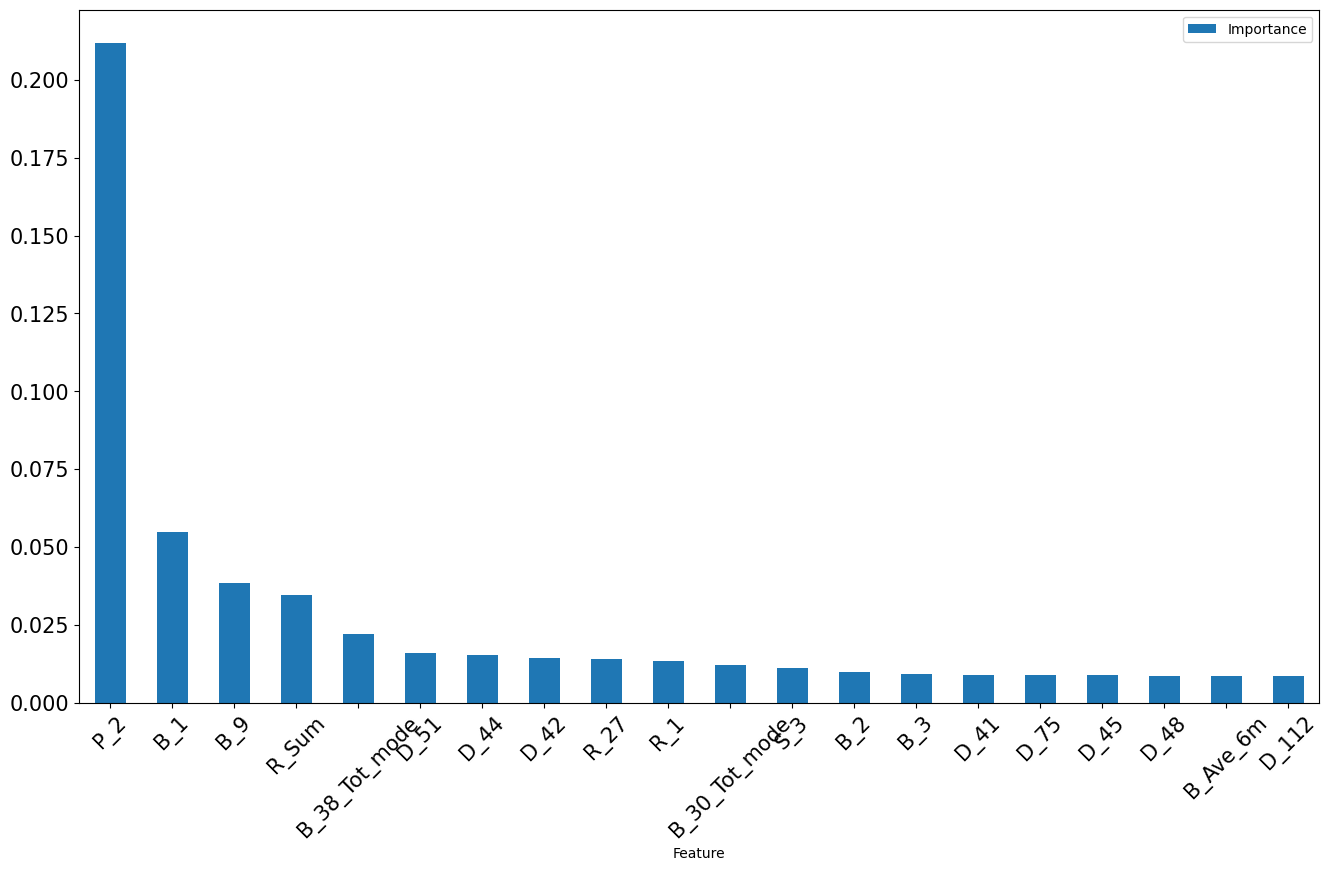

In [111]:
features_imp.head(20).plot(x='Feature', y='Importance', kind='bar', figsize=(16,9), rot=45, fontsize=15)

In [112]:
params = {
    'n_estimators': 300,
    'learning_rate': 0.5,
    'max_depth': 4,
    'subsample': 0.5,
    'colsample_bytree': 0.5,
    'scale_pos_weight': 5
}

# Create XGBoost model
xgb_clf2 = xgboost.XGBClassifier(**params)

In [113]:
xgb_clf2.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [114]:
feature_importances2 = xgb_clf.feature_importances_
features_imp2 = pd.DataFrame({
 'Feature': X_train.columns,
 'Importance': feature_importances2
})
features_imp2.head()

,Feature,Importance
0,P_2,0.211888
1,D_39,0.004438
2,B_1,0.054916
3,B_2,0.009969
4,R_1,0.013282


<Axes: xlabel='Feature'>

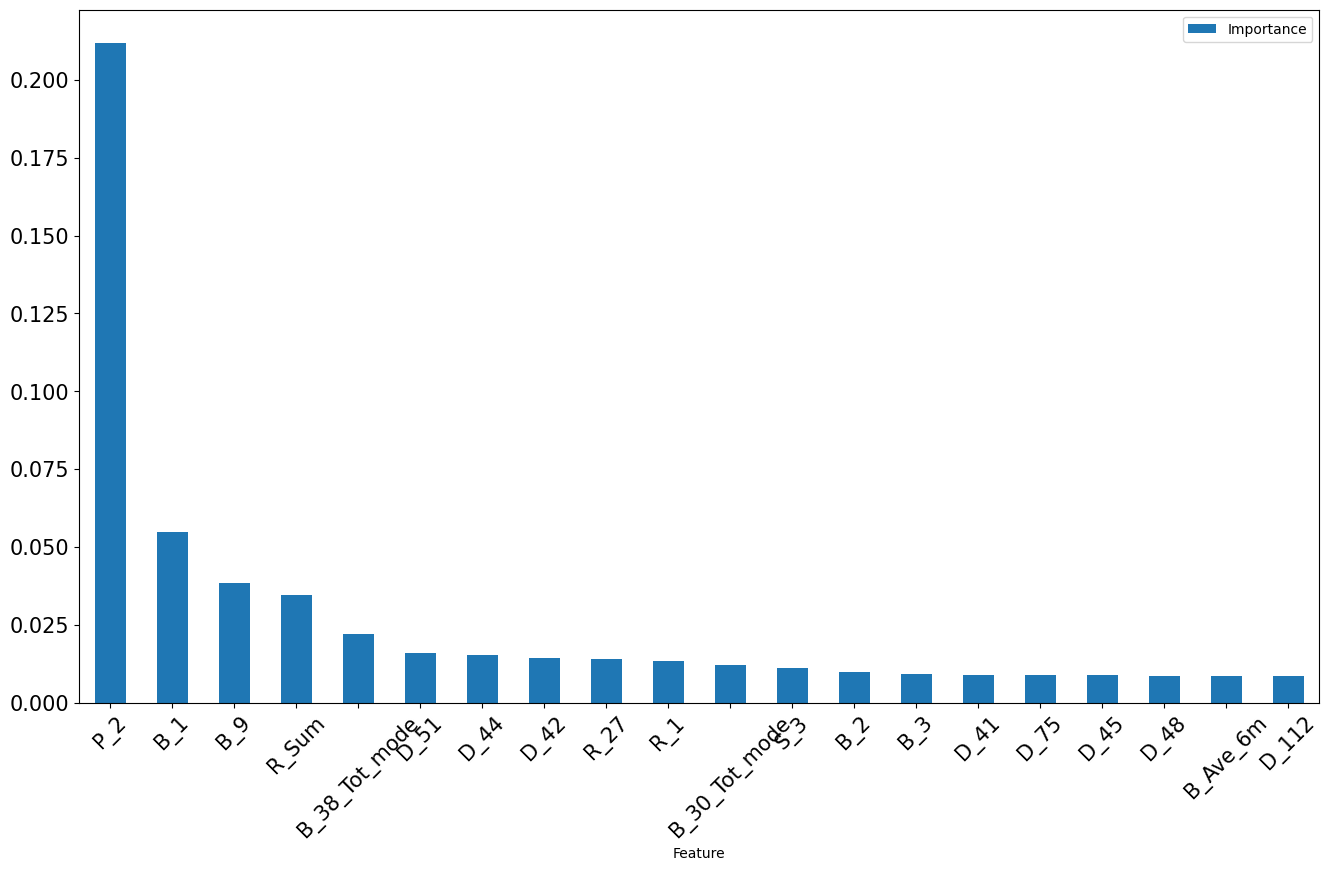

In [115]:
features_imp2 = features_imp2.sort_values("Importance",ascending=[False])
features_imp2.head(20).plot(x='Feature', y='Importance', kind='bar', figsize=(16,9), rot=45, fontsize=15)

In [116]:
features_imp2.to_csv('feature_importances2.csv', index=False)

In [117]:
feature_importances  = pd.concat([features_imp, features_imp2])

In [118]:
feature_importances.shape,features_imp.shape,features_imp2.shape

((776, 2), (388, 2), (388, 2))

In [119]:
feature_importances = feature_importances.groupby(feature_importances.index).max()

In [120]:
feature_importances.shape

(388, 2)

In [121]:
selected_features = feature_importances[feature_importances["Importance"]>=0.5/100].sort_values("Importance",ascending=[False]).reset_index().drop(columns="index")

<Axes: xlabel='Feature'>

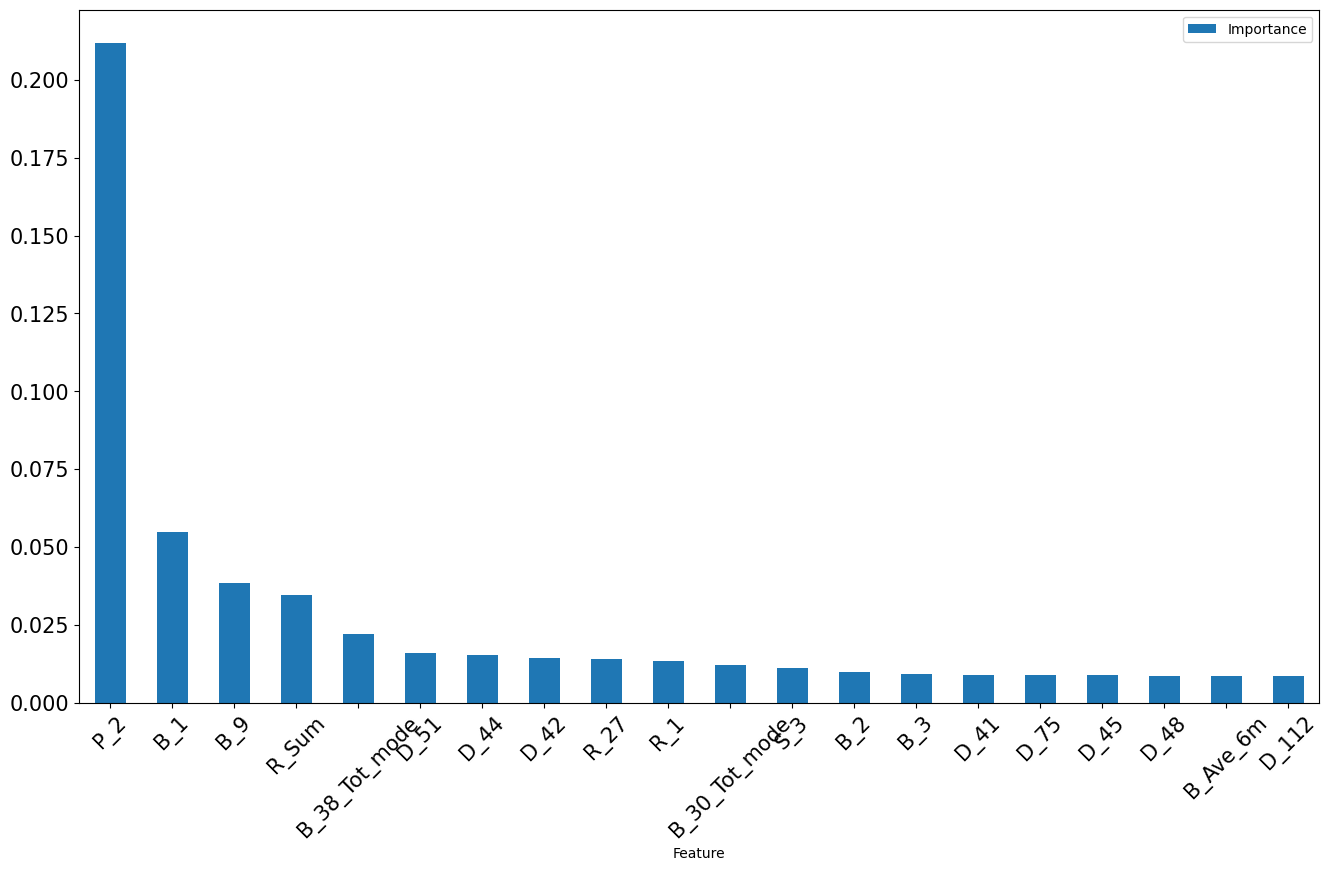

In [122]:
selected_features.head(20).plot(x='Feature', y='Importance', kind='bar', figsize=(16,9), rot=45, fontsize=15)

In [123]:
selected_features.to_csv("selected_features.csv",index=False)

In [15]:
selected_features = pd.read_csv("selected_features.csv")

In [16]:
pre_proc_data.columns

Index(['customer_ID', 'target', 'S_2', 'P_2', 'D_39', 'B_1', 'B_2', 'R_1',
       'S_3', 'D_41',
       ...
       'D_136_null', 'D_137_null', 'D_138_null', 'D_139_null', 'D_140_null',
       'D_141_null', 'D_142_null', 'D_143_null', 'D_144_null', 'D_145_null'],
      dtype='object', length=391)

# Slide 6 

In [17]:
# Get the first letter of each column name
cols = [col for col in list(selected_features["Feature"]) if col not in ['customer_ID',"target"]]
first_letters = [col[0] for col in cols]

# Count the number of columns for each letter
letter_counts = pd.Series(first_letters).value_counts().reset_index()


letter_counts.columns = ["Variable Types","No of Features"]
#letter_counts["Variable Types"] = ["Delinquency variables","Balance variables","Risk variables","Spend variables","Payment variables"]
letter_counts

,Variable Types,No of Features
0,B,15
1,D,15
2,R,4
3,S,3
4,P,1


In [18]:
slide46["No of Selected"] = letter_counts["No of Features"]
slide46
# slide 6

,Variable Types,No of Features,No of Selected
0,B,15,15
1,D,15,15
2,R,4,4
3,S,3,3
4,P,1,1


In [22]:
selected_cols = list(selected_features["Feature"])

# slide 7

In [23]:
# Create an empty DataFrame to store the results
columns = ['Trees', 'LR', 'Subsample', '% Features', 'Weight of Default', 'AUC Train', 'AUC Test 1', 'AUC Test 2']
results_df = pd.DataFrame(columns=columns)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 300],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.5, 0.8],
    'colsample_bytree': [0.5, 1.0],
    'scale_pos_weight': [1, 5, 10]
}

# Initialize XGBoost classifier
xgb_model = XGBClassifier()

# Loop over all combinations of hyperparameters
i = 0
for trees in tqdm(param_grid['n_estimators']):
    for lr in tqdm(param_grid['learning_rate']):
        for subsample in param_grid['subsample']:
            for colsample in param_grid['colsample_bytree']:
                for weight in param_grid['scale_pos_weight']:
                    xgb_model = XGBClassifier(
                        n_estimators=trees,
                        learning_rate=lr,
                        subsample=subsample,
                        colsample_bytree=colsample,
                        scale_pos_weight=weight
                    )
                    xgb_model.fit(X_train[selected_cols], y_train)

                    # Predict probabilities for each set
                    train_pred = xgb_model.predict_proba(X_train[selected_cols])[:, 1]
                    test1_pred = xgb_model.predict_proba(X_test1[selected_cols])[:, 1]
                    test2_pred = xgb_model.predict_proba(X_test2[selected_cols])[:, 1]

                    # Calculate AUC for each set
                    auc_train = roc_auc_score(y_train, train_pred)
                    auc_test1 = roc_auc_score(y_test1, test1_pred)
                    auc_test2 = roc_auc_score(y_test2, test2_pred)

                    # Update the results DataFrame after each combination
                    results_df.loc[i] = [
                        trees, lr, subsample, colsample, weight,
                        auc_train, auc_test1, auc_test2
                    ]
                    i += 1

                    # Save the results after each combination
                    results_df.to_csv('grid_search_results_gpt.csv', index=False)


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [17:41<00:00, 353.83s/it]


In [24]:
grid_results = pd.read_csv("grid_search_results_gpt.csv")
grid_results["Average AUC"] = grid_results[["AUC Train","AUC Test 1","AUC Test 2"]].mean(axis=1)
grid_results["Std AUC"] = grid_results[["AUC Train","AUC Test 1","AUC Test 2"]].std(axis=1)

# Slide 8

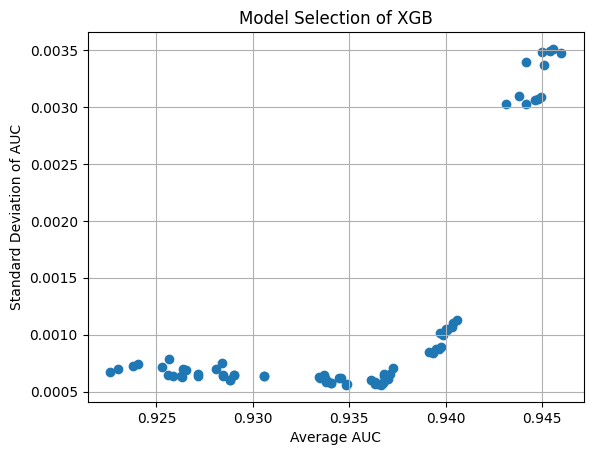

In [25]:
plt.scatter(grid_results["Average AUC"], grid_results["Std AUC"])
plt.grid(True)
plt.xlabel('Average AUC')
plt.ylabel('Standard Deviation of AUC')
plt.title('Model Selection of XGB')
plt.show()# slide 8a

In [26]:
grid_results.sort_values(by=["Std AUC"])

,Trees,LR,Subsample,% Features,Weight of Default,AUC Train,AUC Test 1,AUC Test 2,Average AUC,Std AUC
48,300.0,0.01,0.5,0.5,1.0,0.934791,0.934317,0.935432,0.934846,0.000560
17,50.0,0.10,0.5,1.0,10.0,0.936917,0.936006,0.937024,0.936649,0.000560
13,50.0,0.10,0.5,0.5,5.0,0.936477,0.935721,0.936829,0.936342,0.000566
54,300.0,0.01,0.8,0.5,1.0,0.934878,0.934314,0.935451,0.934881,0.000569
19,50.0,0.10,0.8,0.5,5.0,0.936643,0.935871,0.936981,0.936498,0.000569
55,300.0,0.01,0.8,0.5,5.0,0.933996,0.933520,0.934668,0.934061,0.000577
49,300.0,0.01,0.5,0.5,5.0,0.933935,0.933540,0.934679,0.934051,0.000578
12,50.0,0.10,0.5,0.5,1.0,0.936868,0.936092,0.937228,0.936729,0.000580
20,50.0,0.10,0.8,0.5,10.0,0.936483,0.935675,0.936810,0.936323,0.000584
50,300.0,0.01,0.5,0.5,10.0,0.933711,0.933293,0.934457,0.933820,0.000589


In [27]:
x = grid_results.sort_values(by=["Std AUC"]).reset_index()
x[x["index"]==45]

,index,Trees,LR,Subsample,% Features,Weight of Default,AUC Train,AUC Test 1,AUC Test 2,Average AUC,Std AUC
59,45,100.0,0.1,0.8,1.0,1.0,0.941701,0.939447,0.940565,0.940571,0.001127


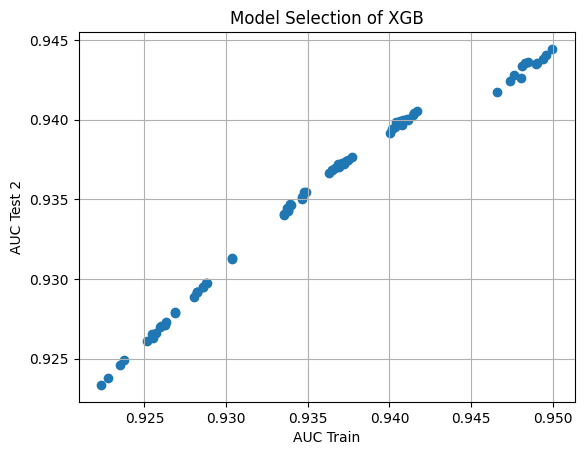

In [28]:

plt.scatter(grid_results["AUC Train"], grid_results["AUC Test 2"])
plt.grid(True)
plt.xlabel('AUC Train')
plt.ylabel('AUC Test 2')
plt.title('Model Selection of XGB')
plt.show()# slide 8b

In [29]:
x = grid_results.sort_values(by=["Std AUC"]).reset_index()
x[x["index"]==45]

,index,Trees,LR,Subsample,% Features,Weight of Default,AUC Train,AUC Test 1,AUC Test 2,Average AUC,Std AUC
59,45,100.0,0.1,0.8,1.0,1.0,0.941701,0.939447,0.940565,0.940571,0.001127


In [30]:
grid_results["overfit_metric"] =(4*(1-grid_results["Average AUC"]))**2 + ((grid_results["AUC Train"]-grid_results["AUC Test 1"])+
                                    (grid_results["AUC Train"]-grid_results["AUC Test 2"]))/grid_results["Average AUC"]

In [31]:
grid_results.sort_values(by=["overfit_metric"]).head(1)

,Trees,LR,Subsample,% Features,Weight of Default,AUC Train,AUC Test 1,AUC Test 2,Average AUC,Std AUC,overfit_metric
69,300.0,0.1,0.8,1.0,1.0,0.949969,0.943565,0.944436,0.94599,0.003473,0.059293


In [138]:
grid_results.head()

,Trees,LR,Subsample,% Features,Weight of Default,AUC Train,AUC Test 1,AUC Test 2,Average AUC,Std AUC,overfit_metric
0,300.0,0.5,0.5,0.5,5.0,0.928578,0.928389,0.929513,0.928827,0.000602,0.080247
1,300.0,0.5,0.5,0.5,5.0,0.926848,0.926759,0.927906,0.927171,0.000638,0.083820
2,300.0,0.5,0.5,0.5,5.0,0.925923,0.925890,0.927014,0.926276,0.000639,0.085822
3,300.0,0.5,0.5,0.5,5.0,0.925457,0.924996,0.926523,0.925659,0.000783,0.087773
4,300.0,0.5,0.5,0.5,5.0,0.923772,0.923486,0.924893,0.924050,0.000744,0.091389


In [32]:

X_train, X_temp, y_train, y_temp = train_test_split(pre_proc_data.drop(columns=["customer_ID","S_2","target"])[selected_cols], pre_proc_data["target"].values, test_size=0.3, random_state=14)

# Now, split X_temp and y_temp into test1 and test2
X_test1, X_test2, y_test1, y_test2 = train_test_split(X_temp, y_temp, test_size=0.5, random_state=14)


In [33]:
xgb_best = XGBClassifier(n_estimators=100,learning_rate=0.1,subsample=0.8,colsample_bytree = 1,scale_pos_weight = 1)

In [34]:
xgb_best.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [35]:

pickle.dump(xgb_best, open("xgb_best.pickle.dat", "wb"))

In [36]:
xgb_best = pickle.load(open("xgb_best.pickle.dat", "rb"))

# Slide 9

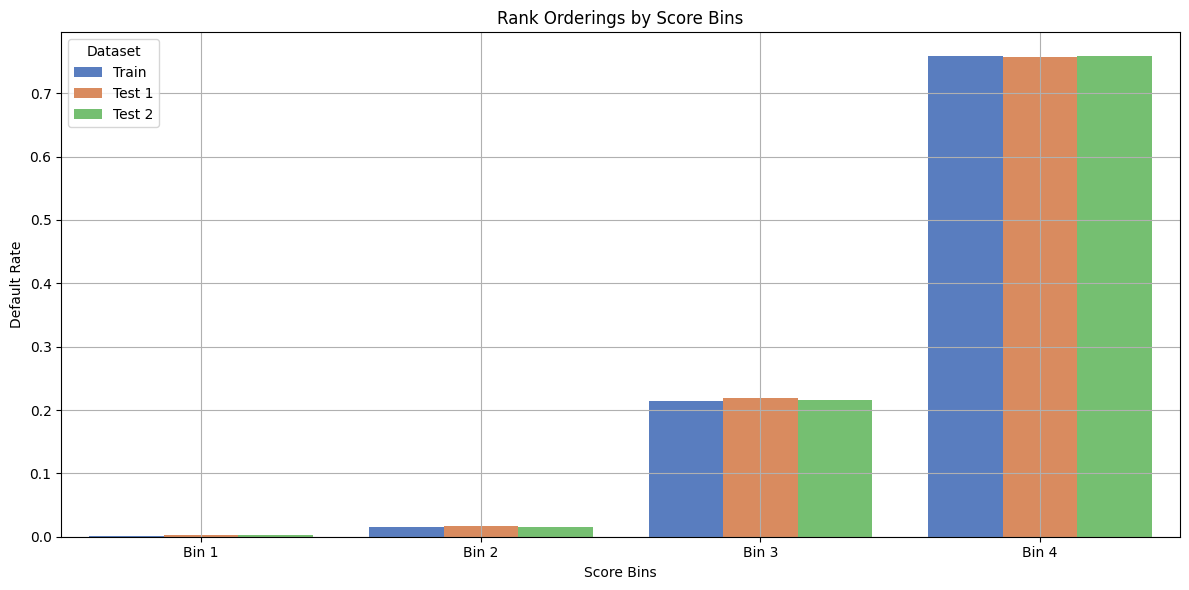

In [37]:
# Define score bins based on the train sample
train_scores = xgb_best.predict_proba(X_train)[:, 1]
bins = np.percentile(train_scores, [0, 25, 50, 75, 100])

# Apply the same thresholds to test samples
test1_scores = xgb_best.predict_proba(X_test1)[:, 1]
test2_scores = xgb_best.predict_proba(X_test2)[:, 1]

# Calculate default rates in each bin for each sample
def calculate_default_rate(scores, y):
    default_rates = []
    for i in range(len(bins) - 1):
        mask = (scores >= bins[i]) & (scores <= bins[i + 1])
        if np.sum(mask) > 0:
            default_rate = np.sum(y[mask]) / np.sum(mask)
            default_rates.append(default_rate)
        else:
            default_rates.append(0.0)
    return default_rates

default_rates_train = calculate_default_rate(train_scores, y_train)
default_rates_test1 = calculate_default_rate(test1_scores, y_test1)
default_rates_test2 = calculate_default_rate(test2_scores, y_test2)

# Create DataFrame for seaborn
import pandas as pd
df = pd.DataFrame({
    'Score Bins': [f"Bin {i+1}" for i in range(len(bins) - 1)],
    'Train': default_rates_train,
    'Test 1': default_rates_test1,
    'Test 2': default_rates_test2
})

# Melt DataFrame for better visualization
df_melted = df.melt(id_vars='Score Bins', var_name='Dataset', value_name='Default Rate')

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x='Score Bins', y='Default Rate', hue='Dataset', data=df_melted, palette='muted')
plt.xlabel('Score Bins')
plt.ylabel('Default Rate')
plt.title('Rank Orderings by Score Bins')
plt.legend(title='Dataset')
plt.grid(True)
plt.tight_layout()
plt.show()


In [38]:
# Define score bins based on the train sample
train_scores = xgb_best.predict_proba(X_train)[:, 1]
bins = np.percentile(train_scores, [0, 25, 50, 75, 100])

# Apply the same thresholds to test samples
test1_scores = xgb_best.predict_proba(X_test1)[:, 1]
test2_scores = xgb_best.predict_proba(X_test2)[:, 1]

# Calculate default rates in each bin for each sample
def calculate_default_rate(scores, y):
    default_rates = []
    for i in range(len(bins) - 1):
        mask = (scores >= bins[i]) & (scores <= bins[i + 1])
        if np.sum(mask) > 0:
            default_rate = np.sum(y[mask]) / np.sum(mask)
            default_rates.append(default_rate)
        else:
            default_rates.append(0.0)
    return default_rates

default_rates_train = calculate_default_rate(train_scores, y_train)
default_rates_test1 = calculate_default_rate(test1_scores, y_test1)
default_rates_test2 = calculate_default_rate(test2_scores, y_test2)

# Create Plotly figure
fig = go.Figure()

# Add bar traces for each dataset
fig.add_trace(go.Bar(x=[f"Bin {i+1}" for i in range(len(bins) - 1)], y=default_rates_train, name='Train'))
fig.add_trace(go.Bar(x=[f"Bin {i+1}" for i in range(len(bins) - 1)], y=default_rates_test1, name='Test 1'))
fig.add_trace(go.Bar(x=[f"Bin {i+1}" for i in range(len(bins) - 1)], y=default_rates_test2, name='Test 2'))

# Add text annotations on top of each bar
annotation_offset = 0.05
for i, bin_label in enumerate([f"Bin {i+1}" for i in range(len(bins) - 1)]):
    fig.add_annotation(x=bin_label, y=default_rates_train[i], xanchor='center', yanchor='bottom',
                       text=f"{default_rates_train[i]:.2f}", showarrow=False,
                       xshift=-50, yshift=10)
    fig.add_annotation(x=bin_label, y=default_rates_test1[i], xanchor='center', yanchor='bottom',
                       text=f"{default_rates_test1[i]:.2f}", showarrow=False,
                       xshift=0, yshift=10)
    fig.add_annotation(x=bin_label, y=default_rates_test2[i], xanchor='center', yanchor='bottom',
                       text=f"{default_rates_test2[i]:.2f}", showarrow=False,
                       xshift=50, yshift=10)

# Update layout
fig.update_layout(barmode='group', xaxis_title='Score Bins', yaxis_title='Default Rate',
                  title='Rank Orderings by Score Bins', legend_title='Dataset')

# Show plot
fig.show()


# Slide 10

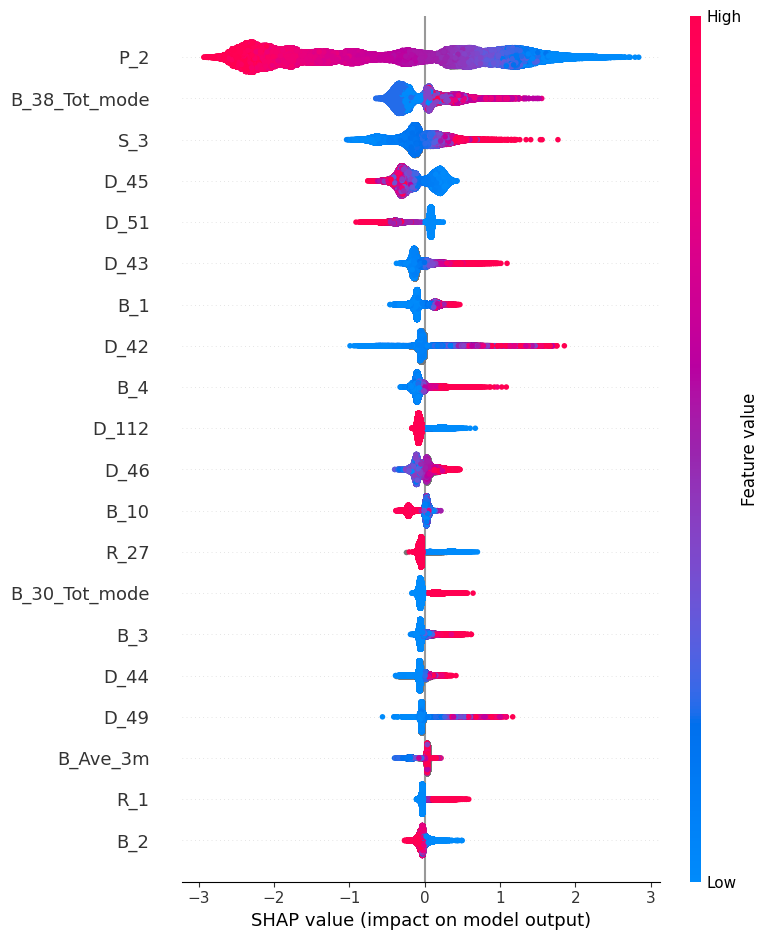

In [39]:
import shap
#shap.initjs()
explainer = shap.Explainer(xgb_best)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test2)

# Generate summary plot
shap.summary_plot(shap_values, X_test2) 
# Show plot
plt.show()


# Slide 11

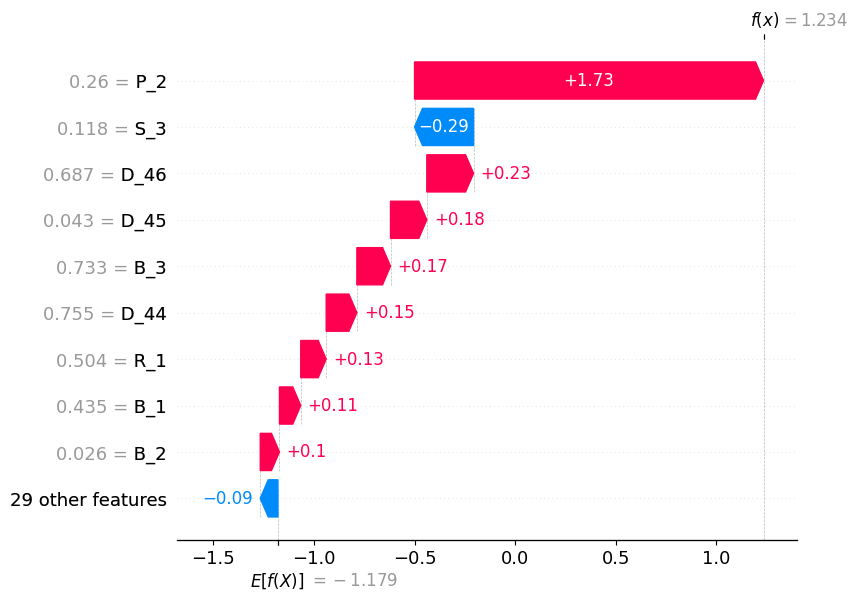

In [40]:
sample_index = 14  # Replace with the index of the sample you want to explain

# Create the Explanation object
explanation = shap.Explanation(values=shap_values[sample_index],
                                base_values=explainer.expected_value,
                                data=X_test2.iloc[sample_index],
                                feature_names=X_test2.columns.tolist())

# Generate the waterfall plot
shap.plots.waterfall(explanation)

# Neural Networks

In [41]:
pre_proc_data = pd.read_csv("pre_proc_data.csv")

In [42]:
selected_features = pd.read_csv("selected_features.csv")

In [43]:
norm_df = pre_proc_data[list(selected_features["Feature"])+["target","customer_ID","S_2"]]

In [44]:
cols = norm_df.drop(columns=["target","customer_ID","S_2"]).columns

In [45]:
from sklearn.model_selection import train_test_split


X_train, X_temp, y_train, y_temp = train_test_split(norm_df.drop(columns=["target"]), norm_df["target"].values, test_size=0.3, random_state=14)

# Now, split X_temp and y_temp into test1 and test2
X_test1, X_test2, y_test1, y_test2 = train_test_split(X_temp, y_temp, test_size=0.5, random_state=14)


# Slide 12

In [46]:
Q1 = X_train[cols].quantile(0.01)
Q99 = X_train[cols].quantile(0.99)


In [47]:
# Replace values below Q1 with Q1 and values above Q99 with Q99
for col in cols:
    X_train[col] = np.where(X_train[col] < Q1[col], Q1[col], X_train[col])
    X_train[col] = np.where(X_train[col] > Q99[col], Q99[col], X_train[col])  

In [48]:
# Replace values below Q1 with Q1 and values above Q99 with Q99
for col in cols:
    X_test1[col] = np.where(X_test1[col] < Q1[col], Q1[col], X_test1[col])
    X_test1[col] = np.where(X_test1[col] > Q99[col], Q99[col], X_test1[col])  

In [49]:
# Replace values below Q1 with Q1 and values above Q99 with Q99
for col in cols:
    X_test2[col] = np.where(X_test2[col] < Q1[col], Q1[col], X_test2[col])
    X_test2[col] = np.where(X_test2[col] > Q99[col], Q99[col], X_test2[col])  

In [50]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train[cols]= scaler.fit_transform(X_train[cols])


In [51]:
X_test1[cols]= scaler.transform(X_test1[cols])


In [52]:
X_test2[cols]= scaler.transform(X_test2[cols])


In [53]:
X_train.describe()

,P_2,B_1,B_9,R_Sum,B_38_Tot_mode,D_51,D_44,D_42,R_27,R_1,B_30_Tot_mode,S_3,B_2,B_3,D_41,D_75,D_45,D_48,B_Ave_6m,D_112,B_Sum,B_8,D_65,B_38_2.0,D_66,D_49,D_46,D_43,B_10,S_23,B_39,R_Ave_6m,B_Ave_3m,D_66_Tot_mode,B_4,S_Ave,D_79,B_11
count,7.678200e+05,7.745760e+05,7.745760e+05,7.745760e+05,7.745760e+05,7.745760e+05,7.363740e+05,1.104590e+05,7.561740e+05,7.745760e+05,7.745760e+05,6.312710e+05,7.742640e+05,7.742640e+05,7.742640e+05,7.745760e+05,7.742640e+05,6.738220e+05,3.712370e+05,7.741890e+05,7.745760e+05,7.715210e+05,7.745760e+05,7.745760e+05,87750.0,7.578800e+04,6.054940e+05,5.407980e+05,7.745760e+05,7.745100e+05,4.446000e+03,3.712370e+05,1.911770e+05,7.745760e+05,7.745760e+05,7.745760e+05,7.638860e+05,7.745760e+05
mean,9.039843e-16,-1.191613e-17,-4.451074e-16,2.546328e-16,8.800876e-17,-6.626801e-17,-2.394065e-16,4.229781e-16,3.294431e-17,5.878258e-17,1.964923e-17,3.283302e-17,-1.457768e-17,-1.870274e-17,-1.410139e-16,3.223869e-16,-2.361153e-16,1.428842e-16,-2.073613e-16,-7.699889e-16,-5.133752e-16,-9.248316e-17,1.483691e-16,6.461681e-17,0.0,-1.565692e-17,-8.855293e-16,4.000102e-17,4.208922e-16,2.607369e-16,-2.739349e-17,-1.491379e-16,-4.816439e-16,7.430383e-17,1.870989e-16,-6.762566e-17,1.930565e-17,7.980781e-19
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000005e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,0.0,1.000007e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000112e+00,1.000001e+00,1.000003e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-2.682832e+00,-5.966361e-01,-7.235107e-01,-8.431651e-01,-1.078731e+00,-6.137443e-01,-5.613671e-01,-9.124268e-01,-2.836945e+00,-3.670717e-01,-3.929007e-01,-1.234580e+00,-1.546119e+00,-5.663324e-01,-3.358916e-01,-7.942811e-01,-1.036944e+00,-1.170351e+00,-1.148718e+00,-2.279212e+00,-1.125821e+00,-9.042181e-01,-2.044233e-01,-7.410834e-01,0.0,-1.012493e+00,-3.476208e+00,-8.372834e-01,-9.949965e-01,-1.051360e+00,-8.726924e-01,-7.416751e-01,-1.144500e+00,-3.581125e-01,-8.124209e-01,-1.912727e+00,-3.383589e-01,-5.456815e-01
25%,-7.329008e-01,-5.555267e-01,-7.017859e-01,-2.933410e-01,-4.323325e-01,-5.987453e-01,-5.433965e-01,-7.383338e-01,3.468411e-01,-3.533616e-01,-3.929007e-01,-5.436552e-01,-1.286308e+00,-5.449354e-01,-3.189144e-01,-7.637821e-01,-8.274049e-01,-9.251412e-01,-7.155356e-01,4.316783e-01,-7.124239e-01,-8.955286e-01,-1.843595e-01,-7.410834e-01,0.0,-6.804742e-01,-3.686428e-01,-6.120634e-01,-8.434791e-01,-2.722729e-01,-6.499441e-01,-2.877302e-01,-7.164511e-01,-3.581125e-01,-6.839756e-01,-8.422261e-01,-3.244512e-01,-5.142227e-01
50%,1.543649e-01,-4.461347e-01,-6.246412e-01,-2.773425e-01,-4.323325e-01,-5.831387e-01,-5.245772e-01,-3.055402e-01,3.558629e-01,-3.390455e-01,-3.929007e-01,-3.370302e-01,4.769001e-01,-5.253755e-01,-3.011856e-01,-4.433313e-01,-2.906487e-01,-2.941727e-01,-3.539893e-01,4.397768e-01,-3.514447e-01,-8.864745e-01,-1.635226e-01,-7.410834e-01,0.0,-2.974975e-01,-1.134119e-01,-3.488770e-01,-3.308958e-01,-2.538712e-01,-3.787975e-01,-2.746098e-01,-3.587545e-01,-3.581125e-01,-4.199885e-01,-5.412868e-02,-3.099279e-01,-4.501958e-01
75%,8.567003e-01,1.274582e-02,5.858591e-01,-1.206147e-01,2.140658e-01,8.279953e-01,8.479276e-02,3.680649e-01,3.648563e-01,-3.248695e-01,-3.929007e-01,1.981121e-01,9.456780e-01,9.443147e-02,-2.834550e-01,4.768958e-01,5.189384e-01,8.930718e-01,4.376854e-01,4.478915e-01,4.052839e-01,1.116651e+00,-1.426304e-01,1.349376e+00,0.0,3.381626e-01,3.105690e-01,2.031999e-01,8.115418e-01,-2.355983e-01,1.252665e-01,-1.400941e-01,4.539075e-01,-3.581125e-01,3.319016e-01,5.486676e-01,-2.954520e-01,-3.995984e-02
max,1.440320e+00,4.341990e+00,3.246769e+00,6.774362e+00,2.799659e+00,3.708338e+00,4.369741e+00,4.235957e+00,3.734811e-01,4.619361e+00,2.545172e+00,4.411679e+00,9.638123e-01,3.789808e+00,5.852856e+00,3.960689e

# Missing value Imputation

In [54]:
X_train.fillna(0,inplace=True)
X_test1.fillna(0,inplace=True)
X_test2.fillna(0,inplace=True)

In [55]:
X_train.drop(columns=["customer_ID","S_2"],inplace=True)
X_test1.drop(columns=["customer_ID","S_2"],inplace=True)
X_test2.drop(columns=["customer_ID","S_2"],inplace=True)

# Slide 13

In [164]:


# Define grid search parameters
hidden_layers = [2, 4]
nodes_per_layer = [4, 6]
activation_functions = ['relu', 'tanh']
dropout_rates = [0.5, 0.0]  # 0.0 means no dropout
batch_sizes = [100, 10000]
epochs = 20

# Initialize results table
results_table = pd.DataFrame(columns=['HL', '# Nodes', 'Activation Function', 'Dropout', 'Batch Size', 'AUC Train', 'AUC Test 1', 'AUC Test 2'])
i=0
# Grid search loop
for hl in tqdm(hidden_layers,desc="HL"):
    for nodes in tqdm(nodes_per_layer,desc="nodes_per_layer"):
        for activation in tqdm(activation_functions,desc="activation_functions"):
            for dropout in tqdm(dropout_rates,desc="dropout_rates"):
                for batch_size in batch_sizes:
                    # Build the neural network
                    model = Sequential()
                    model.add(Dense(nodes, activation=activation, input_dim=X_train.shape[1]))
                    for _ in range(hl - 1):
                        model.add(Dense(nodes, activation=activation))
                        if dropout > 0.0:
                            model.add(Dropout(dropout))
                    model.add(Dense(1, activation='sigmoid'))

                    # Compile the model
                    model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['AUC'])

                    # Train the model
                    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0)
                                        
                    # Evaluate on train and test sets
                    auc_train = roc_auc_score(y_train, model.predict(X_train))
                    auc_test1 = roc_auc_score(y_test1, model.predict(X_test1))
                    auc_test2 = roc_auc_score(y_test2, model.predict(X_test2))

                    # Append results to the table
                    results_table.loc[i] = [hl,nodes,activation,dropout,batch_size,auc_train,auc_test1,auc_test2]
                    i=i+1
                    print(results_table)
                    results_table.to_csv('NN_grid_search_results.csv', index=False)

HL:   0%|          | 0/2 [00:00<?, ?it/s]




24206/24206 ━━━━━━━━━━━━━━━━━━━━ 393s 16ms/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
   HL  # Nodes Activation Function  Dropout  Batch Size  AUC Train  \
0   2        4                relu      0.5         100   0.921326   

   AUC Test 1  AUC Test 2  
0    0.921822    0.922598  
24206/24206 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step


   HL  # Nodes Activation Function  Dropout  Batch Size  AUC Train  \
0   2        4                relu      0.5         100   0.921326   
1   2        4                relu      0.5       10000   0.929180   

   AUC Test 1  AUC Test 2  
0    0.921822    0.922598  
1    0.929744    0.930765  
24206/24206 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
   HL  # Nodes Activation Function  Dropout  Batch Size  AUC Train  \
0   2        4                relu      0.5         100   0.921326   
1   2        4                relu      0.5       10000   0.929180   
2   2        4                relu      0.0         100   0.931440   

   AUC Test 1  AUC Test 2  
0    0.921822    0.922598  
1    0.929744    0.930765  
2    0.931808    0.933141  
24206/24206 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step




dropout_rates: 100%|██████████| 2/2 [2:41:02<00:00, 4831.03s/it]



   HL  # Nodes Activation Function  Dropout  Batch Size  AUC Train  \
0   2        4                relu      0.5         100   0.921326   
1   2        4                relu      0.5       10000   0.929180   
2   2        4                relu      0.0         100   0.931440   
3   2        4                relu      0.0       10000   0.928875   

   AUC Test 1  AUC Test 2  
0    0.921822    0.922598  
1    0.929744    0.930765  
2    0.931808    0.933141  
3    0.929501    0.930451  


24206/24206 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
   HL  # Nodes Activation Function  Dropout  Batch Size  AUC Train  \
0   2        4                relu      0.5         100   0.921326   
1   2        4                relu      0.5       10000   0.929180   
2   2        4                relu      0.0         100   0.931440   
3   2        4                relu      0.0       10000   0.928875   
4   2        4                tanh      0.5         100   0.931428   

   AUC Test 1  AUC Test 2  
0    0.921822    0.922598  
1    0.929744    0.930765  
2    0.931808    0.933141  
3    0.929501    0.930451  
4    0.931955    0.933144  
24206/24206 ━━━━━━━━━━━━━━━━━━━━ 47s 2ms/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 6777s 1s/step


   HL  # Nodes Activation Function  Dropout  Batch Size  AUC Train  \
0   2        4                relu      0.5         100   0.921326   
1   2        4                relu      0.5       10000   0.929180   
2   2        4                relu      0.0         100   0.931440   
3   2        4                relu      0.0       10000   0.928875   
4   2        4                tanh      0.5         100   0.931428   
5   2        4                tanh      0.5       10000   0.927933   

   AUC Test 1  AUC Test 2  
0    0.921822    0.922598  
1    0.929744    0.930765  
2    0.931808    0.933141  
3    0.929501    0.930451  
4    0.931955    0.933144  
5    0.928339    0.929791  
24206/24206 ━━━━━━━━━━━━━━━━━━━━ 979s 40ms/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
   HL  # Nodes Activation Function  Dropout  Batch Size  AUC Train  \
0   2        4                relu      0.5         100   0.921326   
1   2        4                relu   



dropout_rates: 100%|██████████| 2/2 [3:37:50<00:00, 6535.20s/it]

activation_functions: 100%|██████████| 2/2 [6:18:52<00:00, 11366.24s/it]


   HL  # Nodes Activation Function  Dropout  Batch Size  AUC Train  \
0   2        4                relu      0.5         100   0.921326   
1   2        4                relu      0.5       10000   0.929180   
2   2        4                relu      0.0         100   0.931440   
3   2        4                relu      0.0       10000   0.928875   
4   2        4                tanh      0.5         100   0.931428   
5   2        4                tanh      0.5       10000   0.927933   
6   2        4                tanh      0.0         100   0.931996   
7   2        4                tanh      0.0       10000   0.928494   

   AUC Test 1  AUC Test 2  
0    0.921822    0.922598  
1    0.929744    0.930765  
2    0.931808    0.933141  
3    0.929501    0.930451  
4    0.931955    0.933144  
5    0.928339    0.929791  
6    0.932379    0.933602  
7    0.928919    0.930148  


24206/24206 ━━━━━━━━━━━━━━━━━━━━ 11s 460us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 460us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 422us/step
   HL  # Nodes Activation Function  Dropout  Batch Size  AUC Train  \
0   2        4                relu      0.5         100   0.921326   
1   2        4                relu      0.5       10000   0.929180   
2   2        4                relu      0.0         100   0.931440   
3   2        4                relu      0.0       10000   0.928875   
4   2        4                tanh      0.5         100   0.931428   
5   2        4                tanh      0.5       10000   0.927933   
6   2        4                tanh      0.0         100   0.931996   
7   2        4                tanh      0.0       10000   0.928494   
8   2        6                relu      0.5         100   0.932232   

   AUC Test 1  AUC Test 2  
0    0.921822    0.922598  
1    0.929744    0.930765  
2    0.931808    0.933141  
3    0.929501    0.930451  
4    0.931955    0.93

   HL  # Nodes Activation Function  Dropout  Batch Size  AUC Train  \
0   2        4                relu      0.5         100   0.921326   
1   2        4                relu      0.5       10000   0.929180   
2   2        4                relu      0.0         100   0.931440   
3   2        4                relu      0.0       10000   0.928875   
4   2        4                tanh      0.5         100   0.931428   
5   2        4                tanh      0.5       10000   0.927933   
6   2        4                tanh      0.0         100   0.931996   
7   2        4                tanh      0.0       10000   0.928494   
8   2        6                relu      0.5         100   0.932232   
9   2        6                relu      0.5       10000   0.929876   

   AUC Test 1  AUC Test 2  
0    0.921822    0.922598  
1    0.929744    0.930765  
2    0.931808    0.933141  
3    0.929501    0.930451  
4    0.931955    0.933144  
5    0.928339    0.929791  
6    0.932379    0.933602  
7    



dropout_rates: 100%|██████████| 2/2 [06:39<00:00, 199.53s/it]



    HL  # Nodes Activation Function  Dropout  Batch Size  AUC Train  \
0    2        4                relu      0.5         100   0.921326   
1    2        4                relu      0.5       10000   0.929180   
2    2        4                relu      0.0         100   0.931440   
3    2        4                relu      0.0       10000   0.928875   
4    2        4                tanh      0.5         100   0.931428   
5    2        4                tanh      0.5       10000   0.927933   
6    2        4                tanh      0.0         100   0.931996   
7    2        4                tanh      0.0       10000   0.928494   
8    2        6                relu      0.5         100   0.932232   
9    2        6                relu      0.5       10000   0.929876   
10   2        6                relu      0.0         100   0.931681   
11   2        6                relu      0.0       10000   0.930122   

    AUC Test 1  AUC Test 2  
0     0.921822    0.922598  
1     0.929744    

24206/24206 ━━━━━━━━━━━━━━━━━━━━ 11s 463us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 436us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 442us/step
    HL  # Nodes Activation Function  Dropout  Batch Size  AUC Train  \
0    2        4                relu      0.5         100   0.921326   
1    2        4                relu      0.5       10000   0.929180   
2    2        4                relu      0.0         100   0.931440   
3    2        4                relu      0.0       10000   0.928875   
4    2        4                tanh      0.5         100   0.931428   
5    2        4                tanh      0.5       10000   0.927933   
6    2        4                tanh      0.0         100   0.931996   
7    2        4                tanh      0.0       10000   0.928494   
8    2        6                relu      0.5         100   0.932232   
9    2        6                relu      0.5       10000   0.929876   
10   2        6                relu      0.0         100   0.931681   
11   2    

    HL  # Nodes Activation Function  Dropout  Batch Size  AUC Train  \
0    2        4                relu      0.5         100   0.921326   
1    2        4                relu      0.5       10000   0.929180   
2    2        4                relu      0.0         100   0.931440   
3    2        4                relu      0.0       10000   0.928875   
4    2        4                tanh      0.5         100   0.931428   
5    2        4                tanh      0.5       10000   0.927933   
6    2        4                tanh      0.0         100   0.931996   
7    2        4                tanh      0.0       10000   0.928494   
8    2        6                relu      0.5         100   0.932232   
9    2        6                relu      0.5       10000   0.929876   
10   2        6                relu      0.0         100   0.931681   
11   2        6                relu      0.0       10000   0.930122   
12   2        6                tanh      0.5         100   0.931944   
13   2



dropout_rates: 100%|██████████| 2/2 [6:34:46<00:00, 11843.13s/it]

HL:  50%|█████     | 1/2 [13:00:17<13:00:17, 46817.84s/it]

    HL  # Nodes Activation Function  Dropout  Batch Size  AUC Train  \
0    2        4                relu      0.5         100   0.921326   
1    2        4                relu      0.5       10000   0.929180   
2    2        4                relu      0.0         100   0.931440   
3    2        4                relu      0.0       10000   0.928875   
4    2        4                tanh      0.5         100   0.931428   
5    2        4                tanh      0.5       10000   0.927933   
6    2        4                tanh      0.0         100   0.931996   
7    2        4                tanh      0.0       10000   0.928494   
8    2        6                relu      0.5         100   0.932232   
9    2        6                relu      0.5       10000   0.929876   
10   2        6                relu      0.0         100   0.931681   
11   2        6                relu      0.0       10000   0.930122   
12   2        6                tanh      0.5         100   0.931944   
13   2

24206/24206 ━━━━━━━━━━━━━━━━━━━━ 11s 464us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 445us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 3s 535us/step
    HL  # Nodes Activation Function  Dropout  Batch Size  AUC Train  \
0    2        4                relu      0.5         100   0.921326   
1    2        4                relu      0.5       10000   0.929180   
2    2        4                relu      0.0         100   0.931440   
3    2        4                relu      0.0       10000   0.928875   
4    2        4                tanh      0.5         100   0.931428   
5    2        4                tanh      0.5       10000   0.927933   
6    2        4                tanh      0.0         100   0.931996   
7    2        4                tanh      0.0       10000   0.928494   
8    2        6                relu      0.5         100   0.932232   
9    2        6                relu      0.5       10000   0.929876   
10   2        6                relu      0.0         100   0.931681   
11   2    

    HL  # Nodes Activation Function  Dropout  Batch Size  AUC Train  \
0    2        4                relu      0.5         100   0.921326   
1    2        4                relu      0.5       10000   0.929180   
2    2        4                relu      0.0         100   0.931440   
3    2        4                relu      0.0       10000   0.928875   
4    2        4                tanh      0.5         100   0.931428   
5    2        4                tanh      0.5       10000   0.927933   
6    2        4                tanh      0.0         100   0.931996   
7    2        4                tanh      0.0       10000   0.928494   
8    2        6                relu      0.5         100   0.932232   
9    2        6                relu      0.5       10000   0.929876   
10   2        6                relu      0.0         100   0.931681   
11   2        6                relu      0.0       10000   0.930122   
12   2        6                tanh      0.5         100   0.931944   
13   2



dropout_rates: 100%|██████████| 2/2 [05:03<00:00, 151.97s/it]



    HL  # Nodes Activation Function  Dropout  Batch Size  AUC Train  \
0    2        4                relu      0.5         100   0.921326   
1    2        4                relu      0.5       10000   0.929180   
2    2        4                relu      0.0         100   0.931440   
3    2        4                relu      0.0       10000   0.928875   
4    2        4                tanh      0.5         100   0.931428   
5    2        4                tanh      0.5       10000   0.927933   
6    2        4                tanh      0.0         100   0.931996   
7    2        4                tanh      0.0       10000   0.928494   
8    2        6                relu      0.5         100   0.932232   
9    2        6                relu      0.5       10000   0.929876   
10   2        6                relu      0.0         100   0.931681   
11   2        6                relu      0.0       10000   0.930122   
12   2        6                tanh      0.5         100   0.931944   
13   2

24206/24206 ━━━━━━━━━━━━━━━━━━━━ 12s 489us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 474us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 3s 485us/step
    HL  # Nodes Activation Function  Dropout  Batch Size  AUC Train  \
0    2        4                relu      0.5         100   0.921326   
1    2        4                relu      0.5       10000   0.929180   
2    2        4                relu      0.0         100   0.931440   
3    2        4                relu      0.0       10000   0.928875   
4    2        4                tanh      0.5         100   0.931428   
5    2        4                tanh      0.5       10000   0.927933   
6    2        4                tanh      0.0         100   0.931996   
7    2        4                tanh      0.0       10000   0.928494   
8    2        6                relu      0.5         100   0.932232   
9    2        6                relu      0.5       10000   0.929876   
10   2        6                relu      0.0         100   0.931681   
11   2    

    HL  # Nodes Activation Function  Dropout  Batch Size  AUC Train  \
0    2        4                relu      0.5         100   0.921326   
1    2        4                relu      0.5       10000   0.929180   
2    2        4                relu      0.0         100   0.931440   
3    2        4                relu      0.0       10000   0.928875   
4    2        4                tanh      0.5         100   0.931428   
5    2        4                tanh      0.5       10000   0.927933   
6    2        4                tanh      0.0         100   0.931996   
7    2        4                tanh      0.0       10000   0.928494   
8    2        6                relu      0.5         100   0.932232   
9    2        6                relu      0.5       10000   0.929876   
10   2        6                relu      0.0         100   0.931681   
11   2        6                relu      0.0       10000   0.930122   
12   2        6                tanh      0.5         100   0.931944   
13   2



dropout_rates: 100%|██████████| 2/2 [1:49:03<00:00, 3271.63s/it]

activation_functions: 100%|██████████| 2/2 [1:54:07<00:00, 3423.60s/it]


    HL  # Nodes Activation Function  Dropout  Batch Size  AUC Train  \
0    2        4                relu      0.5         100   0.921326   
1    2        4                relu      0.5       10000   0.929180   
2    2        4                relu      0.0         100   0.931440   
3    2        4                relu      0.0       10000   0.928875   
4    2        4                tanh      0.5         100   0.931428   
5    2        4                tanh      0.5       10000   0.927933   
6    2        4                tanh      0.0         100   0.931996   
7    2        4                tanh      0.0       10000   0.928494   
8    2        6                relu      0.5         100   0.932232   
9    2        6                relu      0.5       10000   0.929876   
10   2        6                relu      0.0         100   0.931681   
11   2        6                relu      0.0       10000   0.930122   
12   2        6                tanh      0.5         100   0.931944   
13   2

24206/24206 ━━━━━━━━━━━━━━━━━━━━ 11s 464us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 2s 479us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 3s 481us/step
    HL  # Nodes Activation Function  Dropout  Batch Size  AUC Train  \
0    2        4                relu      0.5         100   0.921326   
1    2        4                relu      0.5       10000   0.929180   
2    2        4                relu      0.0         100   0.931440   
3    2        4                relu      0.0       10000   0.928875   
4    2        4                tanh      0.5         100   0.931428   
5    2        4                tanh      0.5       10000   0.927933   
6    2        4                tanh      0.0         100   0.931996   
7    2        4                tanh      0.0       10000   0.928494   
8    2        6                relu      0.5         100   0.932232   
9    2        6                relu      0.5       10000   0.929876   
10   2        6                relu      0.0         100   0.931681   
11   2    

    HL  # Nodes Activation Function  Dropout  Batch Size  AUC Train  \
0    2        4                relu      0.5         100   0.921326   
1    2        4                relu      0.5       10000   0.929180   
2    2        4                relu      0.0         100   0.931440   
3    2        4                relu      0.0       10000   0.928875   
4    2        4                tanh      0.5         100   0.931428   
5    2        4                tanh      0.5       10000   0.927933   
6    2        4                tanh      0.0         100   0.931996   
7    2        4                tanh      0.0       10000   0.928494   
8    2        6                relu      0.5         100   0.932232   
9    2        6                relu      0.5       10000   0.929876   
10   2        6                relu      0.0         100   0.931681   
11   2        6                relu      0.0       10000   0.930122   
12   2        6                tanh      0.5         100   0.931944   
13   2



dropout_rates: 100%|██████████| 2/2 [05:23<00:00, 161.66s/it]



    HL  # Nodes Activation Function  Dropout  Batch Size  AUC Train  \
0    2        4                relu      0.5         100   0.921326   
1    2        4                relu      0.5       10000   0.929180   
2    2        4                relu      0.0         100   0.931440   
3    2        4                relu      0.0       10000   0.928875   
4    2        4                tanh      0.5         100   0.931428   
5    2        4                tanh      0.5       10000   0.927933   
6    2        4                tanh      0.0         100   0.931996   
7    2        4                tanh      0.0       10000   0.928494   
8    2        6                relu      0.5         100   0.932232   
9    2        6                relu      0.5       10000   0.929876   
10   2        6                relu      0.0         100   0.931681   
11   2        6                relu      0.0       10000   0.930122   
12   2        6                tanh      0.5         100   0.931944   
13   2

24206/24206 ━━━━━━━━━━━━━━━━━━━━ 14s 565us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 3s 526us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 3s 536us/step
    HL  # Nodes Activation Function  Dropout  Batch Size  AUC Train  \
0    2        4                relu      0.5         100   0.921326   
1    2        4                relu      0.5       10000   0.929180   
2    2        4                relu      0.0         100   0.931440   
3    2        4                relu      0.0       10000   0.928875   
4    2        4                tanh      0.5         100   0.931428   
5    2        4                tanh      0.5       10000   0.927933   
6    2        4                tanh      0.0         100   0.931996   
7    2        4                tanh      0.0       10000   0.928494   
8    2        6                relu      0.5         100   0.932232   
9    2        6                relu      0.5       10000   0.929876   
10   2        6                relu      0.0         100   0.931681   
11   2    

    HL  # Nodes Activation Function  Dropout  Batch Size  AUC Train  \
0    2        4                relu      0.5         100   0.921326   
1    2        4                relu      0.5       10000   0.929180   
2    2        4                relu      0.0         100   0.931440   
3    2        4                relu      0.0       10000   0.928875   
4    2        4                tanh      0.5         100   0.931428   
5    2        4                tanh      0.5       10000   0.927933   
6    2        4                tanh      0.0         100   0.931996   
7    2        4                tanh      0.0       10000   0.928494   
8    2        6                relu      0.5         100   0.932232   
9    2        6                relu      0.5       10000   0.929876   
10   2        6                relu      0.0         100   0.931681   
11   2        6                relu      0.0       10000   0.930122   
12   2        6                tanh      0.5         100   0.931944   
13   2



dropout_rates: 100%|██████████| 2/2 [05:38<00:00, 169.44s/it]

HL: 100%|██████████| 2/2 [15:05:27<00:00, 27163.63s/it]   

    HL  # Nodes Activation Function  Dropout  Batch Size  AUC Train  \
0    2        4                relu      0.5         100   0.921326   
1    2        4                relu      0.5       10000   0.929180   
2    2        4                relu      0.0         100   0.931440   
3    2        4                relu      0.0       10000   0.928875   
4    2        4                tanh      0.5         100   0.931428   
5    2        4                tanh      0.5       10000   0.927933   
6    2        4                tanh      0.0         100   0.931996   
7    2        4                tanh      0.0       10000   0.928494   
8    2        6                relu      0.5         100   0.932232   
9    2        6                relu      0.5       10000   0.929876   
10   2        6                relu      0.0         100   0.931681   
11   2        6                relu      0.0       10000   0.930122   
12   2        6                tanh      0.5         100   0.931944   
13   2

In [60]:
results_table = pd.read_csv("NN_grid_search_results.csv")
results_table["Average AUC"] = results_table[["AUC Train","AUC Test 1","AUC Test 2"]].mean(axis=1)
results_table["Std AUC"] = results_table[["AUC Train","AUC Test 1","AUC Test 2"]].std(axis=1)

# slide 14

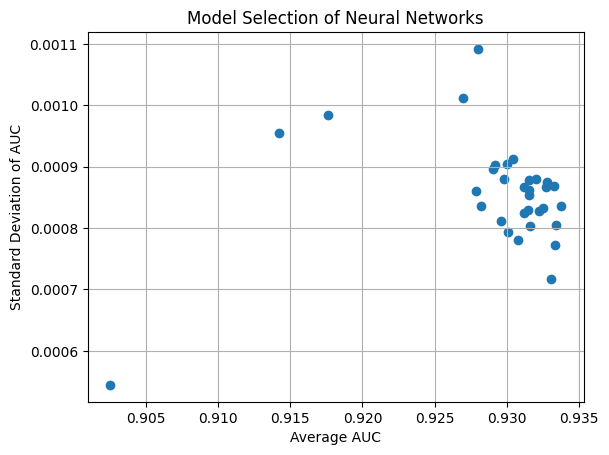

In [61]:
import matplotlib.pyplot as plt
plt.scatter(results_table["Average AUC"], results_table["Std AUC"])
plt.grid(True)
plt.xlabel('Average AUC')
plt.ylabel('Standard Deviation of AUC')
plt.title('Model Selection of Neural Networks')
plt.show()

In [62]:
results_table.sort_values(by=["Std AUC"])

,HL,# Nodes,Activation Function,Dropout,Batch Size,AUC Train,AUC Test 1,AUC Test 2,Average AUC,Std AUC
17,4,4,relu,0.5,10000,0.901981,0.902622,0.903064,0.902556,0.000544
14,2,6,tanh,0.0,100,0.932455,0.932876,0.933852,0.933061,0.000716
26,4,6,relu,0.0,100,0.932653,0.933097,0.934156,0.933302,0.000772
9,2,6,relu,0.5,10000,0.930027,0.930636,0.931575,0.930746,0.000780
23,4,4,tanh,0.0,10000,0.929422,0.929767,0.930935,0.930041,0.000793
24,4,6,relu,0.5,100,0.930896,0.931476,0.932483,0.931618,0.000803
10,2,6,relu,0.0,100,0.932689,0.933282,0.934282,0.933418,0.000805
1,2,4,relu,0.5,10000,0.928850,0.929413,0.930449,0.929571,0.000811
11,2,6,relu,0.0,10000,0.930444,0.930933,0.932052,0.931143,0.000824
2,2,4,relu,0.0,100,0.931478,0.931964,0.933092,0.932178,0.000828


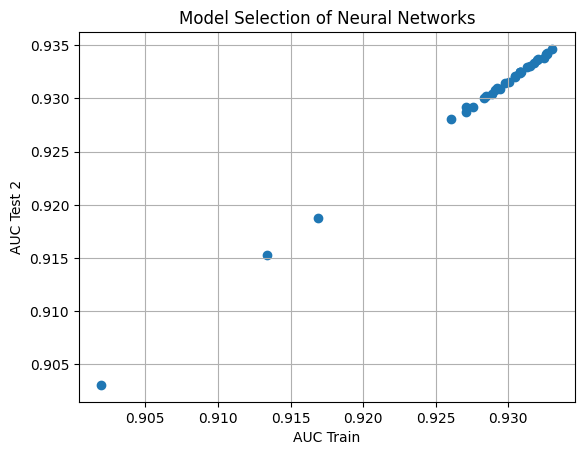

In [63]:
import matplotlib.pyplot as plt
plt.scatter(results_table["AUC Train"], results_table["AUC Test 2"])
plt.grid(True)
plt.xlabel('AUC Train')
plt.ylabel('AUC Test 2')
plt.title('Model Selection of Neural Networks')
plt.show()# slide 14b

In [64]:
results_table.sort_values(by=["AUC Train"]).tail(1)

,HL,# Nodes,Activation Function,Dropout,Batch Size,AUC Train,AUC Test 1,AUC Test 2,Average AUC,Std AUC
30,4,6,tanh,0.0,100,0.933031,0.933526,0.934662,0.93374,0.000836


In [65]:
results_table["overfit_metric"] =(100*(1-results_table["Average AUC"]))**2 + ((results_table["AUC Train"]-results_table["AUC Test 1"])+
                                    (results_table["AUC Train"]-results_table["AUC Test 2"]))/results_table["Average AUC"]

In [66]:
results_table.sort_values(by=["overfit_metric"]).head(1)

,HL,# Nodes,Activation Function,Dropout,Batch Size,AUC Train,AUC Test 1,AUC Test 2,Average AUC,Std AUC,overfit_metric
30,4,6,tanh,0.0,100,0.933031,0.933526,0.934662,0.93374,0.000836,43.901965


In [68]:

results_table['Bias'] = abs(results_table['AUC Train'] - (results_table['AUC Test 1'] + results_table['AUC Test 2']) / 2)
results_table['Variance'] = results_table[['AUC Test 1', 'AUC Test 2']].var(axis=1)
results_table = results_table.sort_values(by=['AUC Train', 'AUC Test 1', 'AUC Test 2',"Bias","Variance"],ascending=[False, False, False,False,False]).reset_index().drop(columns=["index"])

In [69]:
results_table.head(5)

,HL,# Nodes,Activation Function,Dropout,Batch Size,AUC Train,AUC Test 1,AUC Test 2,Average AUC,Std AUC,overfit_metric,Bias,Variance
0,4,6,tanh,0.0,100,0.933031,0.933526,0.934662,0.933740,0.000836,43.901965,0.001063,6.450779e-07
1,2,6,relu,0.0,100,0.932689,0.933282,0.934282,0.933418,0.000805,44.329630,0.001093,4.994070e-07
2,4,6,relu,0.0,100,0.932653,0.933097,0.934156,0.933302,0.000772,44.483912,0.000973,5.604313e-07
3,2,6,tanh,0.5,100,0.932571,0.932956,0.934229,0.933252,0.000868,44.551110,0.001021,8.103213e-07
4,2,6,tanh,0.0,100,0.932455,0.932876,0.933852,0.933061,0.000716,44.806449,0.000909,4.759709e-07


In [70]:
results_table.iloc[4]

HL                             2
# Nodes                        6
Activation Function         tanh
Dropout                      0.0
Batch Size                   100
AUC Train               0.932455
AUC Test 1              0.932876
AUC Test 2              0.933852
Average AUC             0.933061
Std AUC                 0.000716
overfit_metric         44.806449
Bias                    0.000909
Variance                     0.0
Name: 4, dtype: object

In [71]:

hl = 2
nodes = 6
activation = "tanh"
dropout = 0
epochs = 20
batch_size = 100
model = Sequential()
model.add(Dense(nodes, activation=activation, input_dim=X_train.shape[1]))
for _ in range(hl - 1):
    model.add(Dense(nodes, activation=activation))
    if dropout > 0.0:
        model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['AUC'])



In [72]:
# Train the model
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0)

In [73]:
# To save the model
model.save('nn_model.keras')

In [74]:
# To load the model
from keras.models import load_model
nn_model = load_model('nn_model.keras')

In [75]:
# Calculate AUC on each sample
y_train_pred = nn_model.predict(X_train)
y_test1_pred = nn_model.predict(X_test1)
y_test2_pred = nn_model.predict(X_test2)
auc_train = roc_auc_score(y_train, y_train_pred)
auc_test1 = roc_auc_score(y_test1, y_test1_pred)
auc_test2 = roc_auc_score(y_test2, y_test2_pred)
print(f"AUC on Train: {auc_train}")
print(f"AUC on Test 1: {auc_test1}")
print(f"AUC on Test 2: {auc_test2}")


24206/24206 ━━━━━━━━━━━━━━━━━━━━ 18s 732us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 4s 687us/step
5187/5187 ━━━━━━━━━━━━━━━━━━━━ 3s 626us/step
AUC on Train: 0.9327229215546453
AUC on Test 1: 0.9333158524155399
AUC on Test 2: 0.9345586543379899


# Slide 15

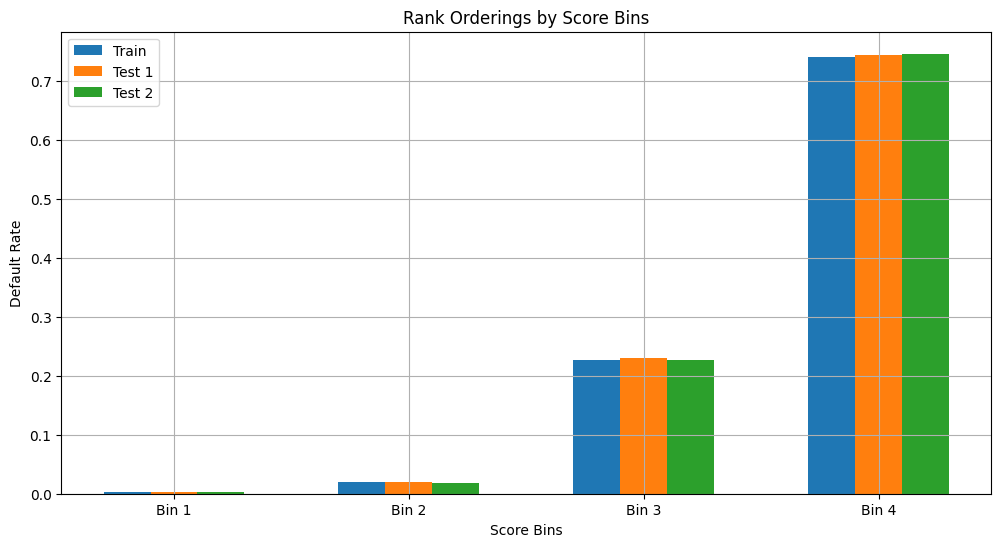

In [76]:
# Define score bins based on the train sample
train_scores = y_train_pred.reshape(-1) 
bins = np.percentile(train_scores, [0, 25, 50, 75, 100])
# Apply the same thresholds to test samples
test1_scores = y_test1_pred.reshape(-1)
test2_scores = y_test2_pred.reshape(-1)
# Calculate default rates in each bin for each sample
def calculate_default_rate(scores, y):
    default_rates = []
    for i in range(len(bins) - 1):
        mask = (scores >= bins[i]) & (scores <= bins[i + 1])
        if np.sum(mask) > 0:
            default_rate = np.sum(y[mask]) / np.sum(mask)
            default_rates.append(default_rate)
        else:
            default_rates.append(0.0)
    return default_rates
default_rates_train = calculate_default_rate(train_scores, y_train)
default_rates_test1 = calculate_default_rate(test1_scores, y_test1)
default_rates_test2 = calculate_default_rate(test2_scores, y_test2)
# bar chart
import matplotlib.pyplot as plt
x = [f"Bin {i+1}" for i in range(len(bins) - 1)]
width = 0.2
x_indexes = np.arange(len(x))
plt.figure(figsize=(12, 6))
plt.bar(x_indexes - width, default_rates_train, width=width, 
label='Train', align='center')
plt.bar(x_indexes, default_rates_test1, width=width, label='Test 1', 
align='center')
plt.bar(x_indexes + width, default_rates_test2, width=width, 
label='Test 2', align='center')
plt.xlabel('Score Bins')
plt.ylabel('Default Rate')
plt.title('Rank Orderings by Score Bins')
plt.xticks(x_indexes, x)
plt.legend()
plt.grid(True)
plt.show()

In [77]:
import plotly.graph_objects as go
import numpy as np

# Define score bins based on the train sample
train_scores = y_train_pred.reshape(-1)
bins = np.percentile(train_scores, [0, 25, 50, 75, 100])

# Apply the same thresholds to test samples
test1_scores = y_test1_pred.reshape(-1)
test2_scores = y_test2_pred.reshape(-1)

# Calculate default rates in each bin for each sample
def calculate_default_rate(scores, y):
    default_rates = []
    for i in range(len(bins) - 1):
        mask = (scores >= bins[i]) & (scores <= bins[i + 1])
        if np.sum(mask) > 0:
            default_rate = np.sum(y[mask]) / np.sum(mask)
            default_rates.append(default_rate)
        else:
            default_rates.append(0.0)
    return default_rates

default_rates_train = calculate_default_rate(train_scores, y_train)
default_rates_test1 = calculate_default_rate(test1_scores, y_test1)
default_rates_test2 = calculate_default_rate(test2_scores, y_test2)

# Create Plotly figure
fig = go.Figure()

# Add bar traces for each dataset
x = [f"Bin {i+1}" for i in range(len(bins) - 1)]
fig.add_trace(go.Bar(x=x, y=default_rates_train, name='Train'))
fig.add_trace(go.Bar(x=x, y=default_rates_test1, name='Test 1'))
fig.add_trace(go.Bar(x=x, y=default_rates_test2, name='Test 2'))

# Add text annotations on top of each bar
annotation_offset = 0.05
for i, bin_label in enumerate([f"Bin {i+1}" for i in range(len(bins) - 1)]):
    fig.add_annotation(x=bin_label, y=default_rates_train[i], xanchor='center', yanchor='bottom',
                       text=f"{default_rates_train[i]:.2f}", showarrow=False,
                       xshift=-50, yshift=10)
    fig.add_annotation(x=bin_label, y=default_rates_test1[i], xanchor='center', yanchor='bottom',
                       text=f"{default_rates_test1[i]:.2f}", showarrow=False,
                       xshift=0, yshift=10)
    fig.add_annotation(x=bin_label, y=default_rates_test2[i], xanchor='center', yanchor='bottom',
                       text=f"{default_rates_test2[i]:.2f}", showarrow=False,
                       xshift=50, yshift=10)

# Update layout
fig.update_layout(barmode='group', xaxis_title='Score Bins', yaxis_title='Default Rate',
                  title='Rank Orderings by Score Bins', legend_title='Dataset')

# Show plot
fig.show()


# Slide 16

In [78]:
grid_results

,Trees,LR,Subsample,% Features,Weight of Default,AUC Train,AUC Test 1,AUC Test 2,Average AUC,Std AUC,overfit_metric
0,50.0,0.01,0.5,0.5,1.0,0.928578,0.928389,0.929513,0.928827,0.000602,0.080247
1,50.0,0.01,0.5,0.5,5.0,0.926848,0.926759,0.927906,0.927171,0.000638,0.083820
2,50.0,0.01,0.5,0.5,10.0,0.925923,0.925890,0.927014,0.926276,0.000639,0.085822
3,50.0,0.01,0.5,1.0,1.0,0.925457,0.924996,0.926523,0.925659,0.000783,0.087773
4,50.0,0.01,0.5,1.0,5.0,0.923772,0.923486,0.924893,0.924050,0.000744,0.091389
5,50.0,0.01,0.5,1.0,10.0,0.922749,0.922449,0.923783,0.922993,0.000700,0.094086
6,50.0,0.01,0.8,0.5,1.0,0.928600,0.928374,0.929520,0.928832,0.000607,0.080291
7,50.0,0.01,0.8,0.5,5.0,0.926864,0.926659,0.927886,0.927136,0.000657,0.084066
8,50.0,0.01,0.8,0.5,10.0,0.926022,0.925865,0.927019,0.926302,0.000626,0.085995
9,50.0,0.01,0.8,1.0,1.0,0.925173,0.924675,0.926084,0.925311,0.000715,0.088808


In [81]:
grid_results.loc[45]



Trees                100.000000
LR                     0.100000
Subsample              0.800000
% Features             1.000000
Weight of Default      1.000000
AUC Train              0.941701
AUC Test 1             0.939447
AUC Test 2             0.940565
Average AUC            0.940571
Std AUC                0.001127
overfit_metric         0.060112
Name: 45, dtype: float64

In [83]:
sorted_results_table = results_table.sort_values(by=["Std AUC"])
selected_result = sorted_results_table.loc[2]

In [85]:
selected_result = sorted_results_table.loc[2]
selected_result   

HL                             4
# Nodes                        6
Activation Function         relu
Dropout                      0.0
Batch Size                   100
AUC Train               0.932653
AUC Test 1              0.933097
AUC Test 2              0.934156
Average AUC             0.933302
Std AUC                 0.000772
overfit_metric         44.483912
Bias                    0.000973
Variance                0.000001
Name: 2, dtype: object

In [185]:
# From the above both we will select XGbosst as final best as the Average AUC of XGBoost is higher than that of Neural Network Model

# Strategy

In [86]:
def strategy(data,target,model_pred,bal,spend,treshold):
    accepted  = data[data[model_pred]<treshold]
    d_rate = accepted[target].mean()
    non_defaulted = accepted[accepted[target]==0]
    rev = (non_defaulted[bal]*0.02+ non_defaulted[spend]*0.001)*12 
    return (accepted[target].mean(),rev.sum())

In [87]:
pre_proc_data = pd.read_csv("pre_proc_data.csv")

In [88]:
# Reset index to bring any index columns into the DataFrame columns
pre_proc_data = pre_proc_data.reset_index(drop=True)

# Drop 'index' and 'level_0' columns if they are still present in the DataFrame
pre_proc_data = pre_proc_data.drop(columns=['index', 'level_0'], errors='ignore')

# Verify the columns
print(pre_proc_data.columns)


Index(['customer_ID', 'target', 'S_2', 'P_2', 'D_39', 'B_1', 'B_2', 'R_1',
       'S_3', 'D_41',
       ...
       'D_136_null', 'D_137_null', 'D_138_null', 'D_139_null', 'D_140_null',
       'D_141_null', 'D_142_null', 'D_143_null', 'D_144_null', 'D_145_null'],
      dtype='object', length=391)


In [89]:
pre_proc_data.dtypes

customer_ID        object
target              int64
S_2                object
P_2               float64
D_39              float64
B_1               float64
B_2               float64
R_1               float64
S_3               float64
D_41              float64
B_3               float64
D_42              float64
D_43              float64
D_44              float64
B_4               float64
D_45              float64
B_5               float64
R_2               float64
D_46              float64
D_47              float64
D_48              float64
D_49              float64
B_6               float64
B_7               float64
B_8               float64
D_50              float64
D_51              float64
B_9               float64
R_3               float64
D_52              float64
P_3               float64
B_10              float64
D_53              float64
S_5               float64
B_11              float64
S_6               float64
D_54              float64
R_4               float64
S_7         

In [90]:
selected_features = pd.read_csv("selected_features.csv")

In [91]:
selected_cols = list(selected_features["Feature"])

In [92]:
xgb_best = pickle.load(open("xgb_best.pickle.dat", "rb"))

In [93]:
xgb_pred = xgb_best.predict_proba(pre_proc_data[selected_cols])

In [94]:
pre_proc_data["S_2"] = pd.to_datetime(pre_proc_data["S_2"])

In [95]:
input_data = pd.DataFrame()
input_data["pred"] = pd.Series(list(xgb_pred[:, 1]))
input_data["target"] = pre_proc_data["target"]
input_data["bal"] = pre_proc_data["B_Ave"]
input_data["spend"] = pre_proc_data["S_Ave"]

In [96]:
output = pd.DataFrame(columns=["Treshold","Default rate","Revenue"])
j = 0
for i in tqdm(range(1,100)):
    dr,r = strategy(input_data,"target","pred","bal","spend",i/10)
    output.loc[j] = [i/10,dr,r]
    j = j+1

100%|██████████| 99/99 [00:05<00:00, 17.46it/s]


In [97]:
output.head()

,Treshold,Default rate,Revenue
0,0.1,0.015522,26925.743313
1,0.2,0.028084,30174.862710
2,0.3,0.041499,32322.994209
3,0.4,0.058304,34079.529078
4,0.5,0.078890,35618.433245


In [98]:
output = output[output["Default rate"]<=0.1]

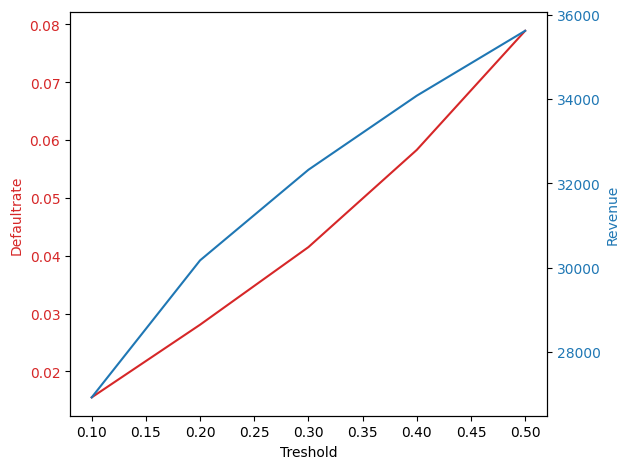

In [99]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Treshold')
ax1.set_ylabel('Defaultrate', color=color)
ax1.plot(output["Treshold"], output["Default rate"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Revenue', color=color)  # we already handled the x-label with ax1
ax2.plot(output["Treshold"], output["Revenue"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [100]:
output

,Treshold,Default rate,Revenue
0,0.1,0.015522,26925.743313
1,0.2,0.028084,30174.862710
2,0.3,0.041499,32322.994209
3,0.4,0.058304,34079.529078
4,0.5,0.078890,35618.433245


# Slide 17

In [101]:
from sklearn.model_selection import train_test_split


X_train, X_temp, y_train, y_temp = train_test_split(pre_proc_data.drop(columns=["target"]), pre_proc_data["target"].values, test_size=0.3, random_state=14)

# Now, split X_temp and y_temp into test1 and test2
X_test1, X_test2, y_test1, y_test2 = train_test_split(X_temp, y_temp, test_size=0.5, random_state=14)


In [102]:
pre_proc_data.shape

(1106538, 391)

In [116]:
def make_table(data,tst,model):
    pred = model.predict_proba(data[selected_cols])
    input_data = pd.DataFrame()
    input_data["pred"] = pd.Series(list(pred[:, 1]))
    input_data["target"] = tst
    input_data["bal"] = data["B_Ave"]
    input_data["spend"] = data["S_Ave"]
    output = pd.DataFrame(columns=["Treshold","Default rate","Revenue"])
    j = 0
    for i in tqdm(range(1,11)):
        dr,r = strategy(input_data,"target","pred","bal","spend",i/10)
        output.loc[j] = [i/10,dr,r]
        j = j+1
    output["# Total"] = len(data)
    return output

In [113]:
def strategy_focused(data, target, model_pred, bal, spend, threshold):
    accepted = data[data[model_pred] < threshold]
    d_rate = accepted[target].mean()
    non_defaulted = accepted[accepted[target] == 0]
    rev = (non_defaulted[bal] * 0.02 + non_defaulted[spend] * 0.001) * 12
    return (accepted[target].mean(), rev.sum())

def make_table_focused(data, tst, model):
    pred = model.predict_proba(data[selected_cols])
    input_data = pd.DataFrame()
    input_data["pred"] = pd.Series(list(pred[:, 1]))
    input_data["target"] = tst
    input_data["bal"] = data["B_Ave"]
    input_data["spend"] = data["S_Ave"]
    output = pd.DataFrame(columns=["Threshold", "Default rate", "Revenue"])
    
    # Loop through thresholds from 0.01 to 1.0 with increments of 0.01
    for threshold in tqdm(np.arange(0.5, 0.61, 0.01)):
        d_rate, revenue = strategy_focused(input_data, "target", "pred", "bal", "spend", threshold)
        output = pd.concat([output, pd.DataFrame({"Threshold": [threshold], "Default rate": [d_rate], "Revenue": [revenue]})], ignore_index=True)
    
    output["# Total"] = len(data)
    return output


In [119]:
train_table_focused = make_table_focused(X_train,y_train,xgb_best)
train_table_focused

100%|██████████| 11/11 [00:00<00:00, 19.11it/s]


,Threshold,Default rate,Revenue,# Total
0,0.50,0.078373,19571.120120,774576
1,0.51,0.080707,19628.991058,774576
2,0.52,0.082985,19680.162857,774576
3,0.53,0.085536,19736.138697,774576
4,0.54,0.087900,19793.769768,774576
5,0.55,0.090426,19849.689948,774576
6,0.56,0.092895,19908.143271,774576
7,0.57,0.095564,19958.481323,774576
8,0.58,0.098219,20007.953530,774576
9,0.59,0.100999,20060.009477,774576


In [120]:
test1_table_focused = make_table_focused(X_test1,y_test1,xgb_best)
test2_table_focused

100%|██████████| 11/11 [00:00<00:00, 94.27it/s]


,Threshold,Default rate,Revenue,# Total
0,0.50,0.079540,886.678579,165981
1,0.51,0.081964,888.638342,165981
2,0.52,0.084197,890.793895,165981
3,0.53,0.086733,893.196300,165981
4,0.54,0.089209,895.365283,165981
5,0.55,0.091878,897.871799,165981
6,0.56,0.094453,900.418555,165981
7,0.57,0.097141,902.392947,165981
8,0.58,0.099973,905.239448,165981
9,0.59,0.102831,907.206728,165981


In [121]:
test2_table_focused = make_table_focused(X_test2,y_test2,xgb_best)
test1_table_focused

100%|██████████| 11/11 [00:00<00:00, 92.66it/s]


,Threshold,Default rate,Revenue,# Total
0,0.50,0.080660,875.825068,165981
1,0.51,0.083267,877.637897,165981
2,0.52,0.085592,880.829499,165981
3,0.53,0.088144,883.453612,165981
4,0.54,0.090579,885.907205,165981
5,0.55,0.093181,888.658475,165981
6,0.56,0.095712,891.458302,165981
7,0.57,0.098334,893.676817,165981
8,0.58,0.101136,895.845090,165981
9,0.59,0.104330,898.014380,165981


In [125]:
full_table_focused = pd.concat([train_table_focused.add_suffix('_Train'),
                        test1_table_focused.drop(columns =["Threshold"]).add_suffix('_test1'),
                        test2_table_focused.drop(columns =["Threshold"]).add_suffix('_test2')],axis=1)
full_table_focused

,Threshold_Train,Default rate_Train,Revenue_Train,# Total_Train,Default rate_test1,Revenue_test1,# Total_test1,Default rate_test2,Revenue_test2,# Total_test2
0,0.50,0.078373,19571.120120,774576,0.080660,875.825068,165981,0.079540,886.678579,165981
1,0.51,0.080707,19628.991058,774576,0.083267,877.637897,165981,0.081964,888.638342,165981
2,0.52,0.082985,19680.162857,774576,0.085592,880.829499,165981,0.084197,890.793895,165981
3,0.53,0.085536,19736.138697,774576,0.088144,883.453612,165981,0.086733,893.196300,165981
4,0.54,0.087900,19793.769768,774576,0.090579,885.907205,165981,0.089209,895.365283,165981
5,0.55,0.090426,19849.689948,774576,0.093181,888.658475,165981,0.091878,897.871799,165981
6,0.56,0.092895,19908.143271,774576,0.095712,891.458302,165981,0.094453,900.418555,165981
7,0.57,0.095564,19958.481323,774576,0.098334,893.676817,165981,0.097141,902.392947,165981
8,0.58,0.098219,20007.953530,774576,0.101136,895.845090,165981,0.099973,905.239448,165981
9,0.59,0.100999,20060.009477,774576,0.104330,898.014380,165981,0.102831,907.206728,165981


In [118]:
train_table_focused = make_table_focused(X_train,y_train,xgb_best)
test1_table_focused = make_table_focused(X_test1,y_test1,xgb_best)
test2_table_focused = make_table_focused(X_test2,y_test2,xgb_best)
train_table_focused
test2_table_focused
test1_table_focused



100%|██████████| 11/11 [00:00<00:00, 91.87it/s]


,Threshold,Default rate,Revenue,# Total
0,0.50,0.080660,875.825068,165981
1,0.51,0.083267,877.637897,165981
2,0.52,0.085592,880.829499,165981
3,0.53,0.088144,883.453612,165981
4,0.54,0.090579,885.907205,165981
5,0.55,0.093181,888.658475,165981
6,0.56,0.095712,891.458302,165981
7,0.57,0.098334,893.676817,165981
8,0.58,0.101136,895.845090,165981
9,0.59,0.104330,898.014380,165981


In [104]:
X_train.shape

(774576, 390)

In [117]:
train_table = make_table(X_train,y_train,xgb_best)
train_table

100%|██████████| 10/10 [00:00<00:00, 17.26it/s]


,Treshold,Default rate,Revenue,# Total
0,0.1,0.015323,15735.109017,774576
1,0.2,0.027685,17283.427893,774576
2,0.3,0.040992,18237.343012,774576
3,0.4,0.057814,18961.866024,774576
4,0.5,0.078373,19571.120120,774576
5,0.6,0.103890,20111.033462,774576
6,0.7,0.136774,20582.518420,774576
7,0.8,0.177648,20982.404133,774576
8,0.9,0.220869,21204.332247,774576
9,1.0,0.247455,21237.435210,774576


In [106]:
test1_table = make_table(X_test1,y_test1,xgb_best)
test1_table

100%|██████████| 10/10 [00:00<00:00, 65.50it/s]


,Treshold,Default rate,Revenue,# Total
0,0.1,0.016308,704.619987,165981
1,0.2,0.029390,772.623935,165981
2,0.3,0.042923,814.934135,165981
3,0.4,0.060050,846.595935,165981
4,0.5,0.080660,875.825068,165981
5,0.6,0.107278,900.483533,165981
6,0.7,0.139014,922.662171,165981
7,0.8,0.180321,940.027383,165981
8,0.9,0.223628,950.559737,165981
9,1.0,0.249854,952.773782,165981


In [107]:
test2_table = make_table(X_test2,y_test2,xgb_best)
test2_table

100%|██████████| 10/10 [00:00<00:00, 102.85it/s]


,Treshold,Default rate,Revenue,# Total
0,0.1,0.015665,715.587262,165981
1,0.2,0.028648,781.923418,165981
2,0.3,0.042448,824.387136,165981
3,0.4,0.058850,855.757656,165981
4,0.5,0.079540,886.678579,165981
5,0.6,0.105745,910.131629,165981
6,0.7,0.138871,931.181490,165981
7,0.8,0.180161,948.975922,165981
8,0.9,0.223382,960.682617,165981
9,1.0,0.249770,962.286210,165981


In [108]:
full_table = pd.concat([train_table.add_suffix('_Train'),
                        test1_table.drop(columns =["Treshold"]).add_suffix('_test1'),
                        test2_table.drop(columns =["Treshold"]).add_suffix('_test2')],axis=1)
full_table

,Treshold_Train,Default rate_Train,Revenue_Train,# Total_Train,Default rate_test1,Revenue_test1,# Total_test1,Default rate_test2,Revenue_test2,# Total_test2
0,0.1,0.015323,15735.109017,774576,0.016308,704.619987,165981,0.015665,715.587262,165981
1,0.2,0.027685,17283.427893,774576,0.029390,772.623935,165981,0.028648,781.923418,165981
2,0.3,0.040992,18237.343012,774576,0.042923,814.934135,165981,0.042448,824.387136,165981
3,0.4,0.057814,18961.866024,774576,0.060050,846.595935,165981,0.058850,855.757656,165981
4,0.5,0.078373,19571.120120,774576,0.080660,875.825068,165981,0.079540,886.678579,165981
5,0.6,0.103890,20111.033462,774576,0.107278,900.483533,165981,0.105745,910.131629,165981
6,0.7,0.136774,20582.518420,774576,0.139014,922.662171,165981,0.138871,931.181490,165981
7,0.8,0.177648,20982.404133,774576,0.180321,940.027383,165981,0.180161,948.975922,165981
8,0.9,0.220869,21204.332247,774576,0.223628,950.559737,165981,0.223382,960.682617,165981
9,1.0,0.247455,21237.435210,774576,0.249854,952.773782,165981,0.249770,962.286210,165981


# Slide 1

In [209]:
full_table[(full_table["Treshold_Train"]==0.2)|(full_table["Treshold_Train"]==0.5)]

,Treshold_Train,Default rate_Train,Revenue_Train,# Total_Train,Default rate_test1,Revenue_test1,# Total_test1,Default rate_test2,Revenue_test2,# Total_test2
1,0.2,0.003079,15375.795454,774576,0.014974,678.393740,165981,0.014941,689.080586,165981
4,0.5,0.015491,17684.288569,774576,0.032888,776.027196,165981,0.032167,789.129422,165981


In [210]:
grid_results.sort_values(by=["Average AUC"]).tail()

,Trees,LR,Subsample,% Features,Weight of Default,AUC Train,AUC Test 1,AUC Test 2,Average AUC,Std AUC,overfit_metric
64,300.0,0.5,0.5,0.5,5.0,0.948963,0.942523,0.943465,0.944984,0.003478,0.061062
71,300.0,0.5,0.5,0.5,5.0,0.949007,0.942852,0.943543,0.945134,0.003372,0.060457
70,300.0,0.5,0.5,0.5,5.0,0.949433,0.943053,0.943800,0.945429,0.003488,0.060354
63,300.0,0.5,0.5,0.5,5.0,0.949601,0.943114,0.944037,0.945584,0.003509,0.060121
69,300.0,0.5,0.5,0.5,5.0,0.949969,0.943565,0.944436,0.945990,0.003473,0.059293


In [211]:
results_table.head()

,HL,# Nodes,Activation Function,Dropout,Batch Size,AUC Train,AUC Test 1,AUC Test 2,Average AUC,Std AUC,overfit_metric,Bias,Variance
0,2,6,tanh,0.0,100,0.932673,0.933142,0.934129,0.933315,0.000743,44.467331,0.000962,4.873876e-07
1,4,6,relu,0.0,100,0.932642,0.933144,0.934227,0.933337,0.000810,44.436725,0.001044,5.863076e-07
2,2,6,relu,0.5,100,0.932232,0.932819,0.933809,0.932953,0.000797,44.950023,0.001082,4.899636e-07
3,4,6,tanh,0.0,100,0.932213,0.932591,0.933754,0.932853,0.000803,45.085368,0.000959,6.759073e-07
4,2,4,tanh,0.0,100,0.931996,0.932379,0.933602,0.932659,0.000839,45.346315,0.000994,7.476814e-07


In [212]:
grid_results.sort_values(by="AUC Train",ascending=False)[['AUC Train', 'AUC Test 1', 'AUC Test 2']].head(1)

,AUC Train,AUC Test 1,AUC Test 2
69,0.949969,0.943565,0.944436


In [213]:
list(results_table.sort_values(by="Std AUC",ascending=True)[['AUC Train', 'AUC Test 1', 'AUC Test 2']].head(1).iloc[0])

[0.9213264353822458, 0.9218219054003114, 0.922598013250862]

In [214]:
gf = grid_results.sort_values(by="AUC Train",ascending=False)[['AUC Train', 'AUC Test 1', 'AUC Test 2']].head(1)
gf

,AUC Train,AUC Test 1,AUC Test 2
69,0.949969,0.943565,0.944436


In [215]:
gf.loc[1] = list(results_table.sort_values(by="Std AUC",ascending=True)[['AUC Train', 'AUC Test 1', 'AUC Test 2']].head(1).iloc[0])

In [216]:
gf["model"] = ["XGB","Neural Nets"]

In [217]:
gf = gf.set_index(["model"])

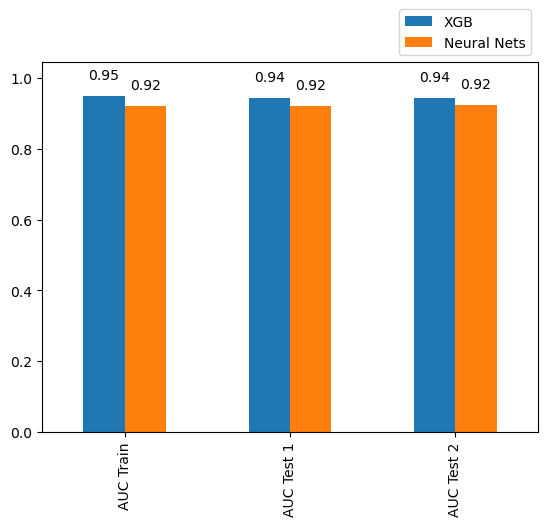

In [218]:
# Plot the bar chart
ax = gf.T.plot(kind="bar")

# Set y-range (ylim)
ax.set_ylim(0, max(gf.max()) * 1.1)  # Adjust the multiplier as needed

# Add annotations
for i in ax.patches:
    ax.annotate(format(i.get_height(), '.2f'), 
                (i.get_x() + i.get_width() / 2., i.get_height()), 
                ha = 'center', va = 'bottom', 
                xytext = (0, 10),  # Adjust the y-offset for bottom position
                textcoords = 'offset points')

# Move the legend to the right corner
ax.legend(loc='lower right', bbox_to_anchor=(1, 1))

plt.show()